### Khởi tạo post_df và replies_df

In [8]:
import pandas as pd
import numpy as np
import json 
from dateutil.parser import isoparser
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
posts_df = pd.read_csv("cleaned_posts.csv")
replies_df = pd.read_csv('cleaned_replies.csv')

### Phân tích nội dung thuần


#### 1. Sử dụng `wordcloud` để biễu diễn cơ bản về những `keyword` sẽ xuất hiện trong bài đăng của người dùng.


In [9]:
from collections import Counter
import re
from nltk import ngrams

# Kết hợp tất cả văn bản từ cột 'originalContent'
all_text = " ".join(content for content in posts_df.originalContent)

# Chuyển tất cả văn bản thành chữ thường và loại bỏ các ký tự đặc biệt
all_text = re.sub(r'\W+', ' ', all_text.lower())

# Tách văn bản thành các từ riêng lẻ
words = all_text.split()

# Tạo các bigrams (cặp từ)
bigrams = ngrams(words, 2)

# Đếm tần suất xuất hiện của các bigrams
bigram_counts = Counter(bigrams)

# Chuyển đổi kết quả thành dataframe để dễ dàng xử lý
bigram_counts_df = pd.DataFrame(bigram_counts.items(), columns=['bigram', 'count']).sort_values(by='count', ascending=False)

# Hiển thị 20 bigrams phổ biến nhất
bigram_counts_df.head(20)

,bigram,count
511,"(thị, trường)",33382
36,"(cổ, phiếu)",28756
1371,"(đầu, tư)",18350
546,"(có, thể)",14908
296,"(giao, dịch)",13278
487,"(chứng, khoán)",11266
1744,"(anh, em)",10454
402,"(hôm, nay)",10278
955,"(hỗ, trợ)",9684
565,"(tiếp, tục)",9382


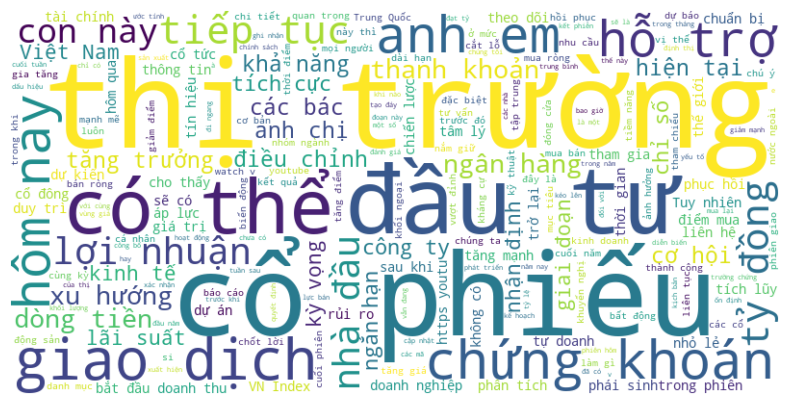

In [10]:

# Kết hợp tất cả văn bản từ cột 'originalContent'
text = " ".join(content for content in posts_df.originalContent)

# Tạo wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nhận xét:
- Ngoài `cổ phiếu`, `giao dịch`, `thị trường` thì có 1 số keyword đáng chú ý là `thanh khoản`, `điểm mua`, `kỳ vọng` là những keyword đáng chú ý.

#### 2. Đặt vấn đề về những yếu tố phân tích được có xuất hiện trong nội dung của các bài viết. 

Để phân tích ta sẽ sử dụng thư viện `re` để tìm các đường link trong cột `originalContent` của dataframe `posts_df`.

In [11]:

import re

# Tìm tất cả các đường link trong cột 'originalContent'
posts_df['links'] = posts_df['originalContent'].apply(lambda x: re.findall(r'(https?://\S+)', x))

# Chuyển sentiment từ dạng số sang string
posts_df['sentiment'] = posts_df['sentiment'].astype('string')
posts_df['sentiment'] = posts_df['sentiment'].replace({'1': 'positive', '0': 'neutral', '-1': 'negative'})

# Tạo một dataframe mới chỉ chứa các bài viết có đường link
links_df = posts_df.explode('links')[['date', 'postID', 'links', 'sentiment']].dropna().reset_index(drop=True)

links_df
# Trích xuất loại links từ cột 'links'
links_df['links'] = links_df['links'].apply(lambda x: x.replace('youtu.be', 'youtube.com') if 'youtu.be' in x else x)
links_df['link_type'] = links_df['links'].apply(lambda x: re.search(r'https?://(?:www\.)?([^/]+)', x).group(1) if re.search(r'https?://(?:www\.)?([^/]+)', x) else None)

links_df


,date,postID,links,sentiment,link_type
0,2024-11-06T21:38:45.743+07:00,29104016,https://www.youtube.com/live/rfLkHPX-CJo?si=5x...,neutral,youtube.com
1,2024-11-06T21:38:26.107+07:00,29104004,https://chungkhoannhatrang.vn/khanh-hoa-ban-ha...,neutral,chungkhoannhatrang.vn
2,2024-11-06T21:35:57.05+07:00,29103932,https://youtube.com/shorts/rH3OON8pU2A?si=8wCa...,neutral,youtube.com
3,2024-11-06T21:33:38.58+07:00,29103860,https://www.youtube.com/watch?v=5Aj7jDO1VSY&t=11s,positive,youtube.com
4,2024-11-06T21:28:34.473+07:00,29103739,https://youtube.com/clip/UgkxkjaCQ0bGfS64zvuSt...,neutral,youtube.com
...,...,...,...,...,...
10648,2024-09-06T10:17:02.76+07:00,28009227,https://youtube.com/live/aIB78pZQilg?feature=s...,neutral,youtube.com
10649,2024-09-06T10:14:16.993+07:00,28009092,https://f247.com/t/hpg-cho-doi-lan-gio-chinh-s...,neutral,f247.com
10650,2024-09-06T10:12:48.367+07:00,28009016,https://youtube.com/wERiDcK2BNA?si=aa3TpE65HYR...,neutral,youtube.com
10651,2024-09-06T10:11:00.183+07:00,28008910,https://f247.com/t/vn-index-dung-de-nghi-ngo-l...,neutral,f247.com


Mã trên sẽ tạo một dataframe `links_df` chứa các đường link và mã bài viết tương ứng.

In [12]:
# Lập bảng thống kê số lượng links theo loại
link_type_counts = links_df['link_type'].value_counts().reset_index()
link_type_counts.columns = ['link_type', 'count']
link_type_counts

,link_type,count
0,youtube.com,7899
1,vt.tiktok.com,334
2,baomoi.com,269
3,fireant.vn,185
4,f247.com,149
...,...,...
363,soha.vn,1
364,finance.vietstock.vn,1
365,ximangsaison.com,1
366,onsenfuji.com.vn,1


In [13]:
import plotly.express as px

# Lấy 5 loại link phổ biến nhất
top_5_links = link_type_counts['link_type'][:5].tolist()

# Thay thế các loại link ít phổ biến bằng 'others'
links_df['link_type'] = links_df['link_type'].apply(lambda x: x if x in top_5_links else 'others')

# Đếm số lần xuất hiện của từng loại link
link_type_counts = links_df['link_type'].value_counts().reset_index()
link_type_counts.columns = ['link_type', 'count']

# Tạo pie chart cải tiến
fig = px.pie(
    link_type_counts, 
    values='count', 
    names='link_type', 
    title='Top 5 Link Types by Appearance',
    color_discrete_sequence=px.colors.sequential.RdBu,  # Chọn bảng màu đẹp mắt
    hole=0.5  # Biểu đồ dạng Donut
)

# Tùy chỉnh hiển thị
fig.update_traces(
    textinfo='percent+label',  # Hiển thị cả tên và phần trăm
    hoverinfo='label+percent+value',  # Chi tiết khi di chuột
    pull=[0.1, 0, 0, 0, 0]  # Làm nổi bật loại link có tần suất cao nhất
)

fig.update_layout(
    title=dict(
        text='Top 5 Link Types by Appearance',
        font=dict(size=20, family='Arial', color='black', weight='bold'),
        x=0.5,  # Căn giữa tiêu đề
        y= 0.98
    ),
    legend=dict(
        title="Link Types",
        font=dict(size=14),
        orientation="h",  # Hiển thị chú thích ngang
        x=0.5,
        xanchor="center",
        y=-0.1  # Vị trí dưới biểu đồ
    )
)

# Hiển thị biểu đồ
fig.show()


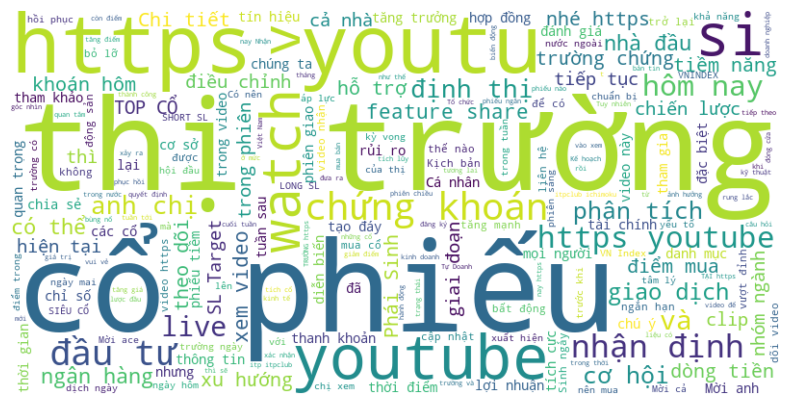

In [14]:
# Merge links_df with posts_df to include the originalContent column
links_df = links_df.merge(posts_df[['postID', 'originalContent']], on='postID', how='left', suffixes=('', '_post'))
# Fill NaN values in 'originalContent' with an empty string
links_df['originalContent'] = links_df['originalContent'].fillna('')
# Wordcloud cho các bài viết chứa link youtube
youtube_text = " ".join(content for content in links_df[links_df['link_type'] == 'youtube.com']['originalContent'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(youtube_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()





Có thể thấy rằng đa số các liên kết trong bài viết đều dẫn đến các trang web bên ngoài, trong đó có nhiều liên kết đến `youtube.com`.

Vậy ta có thể kết luận rằng người dùng thường chia sẻ các liên kết đến các trang web bên ngoài như `youtube.com` trong các bài viết của mình.


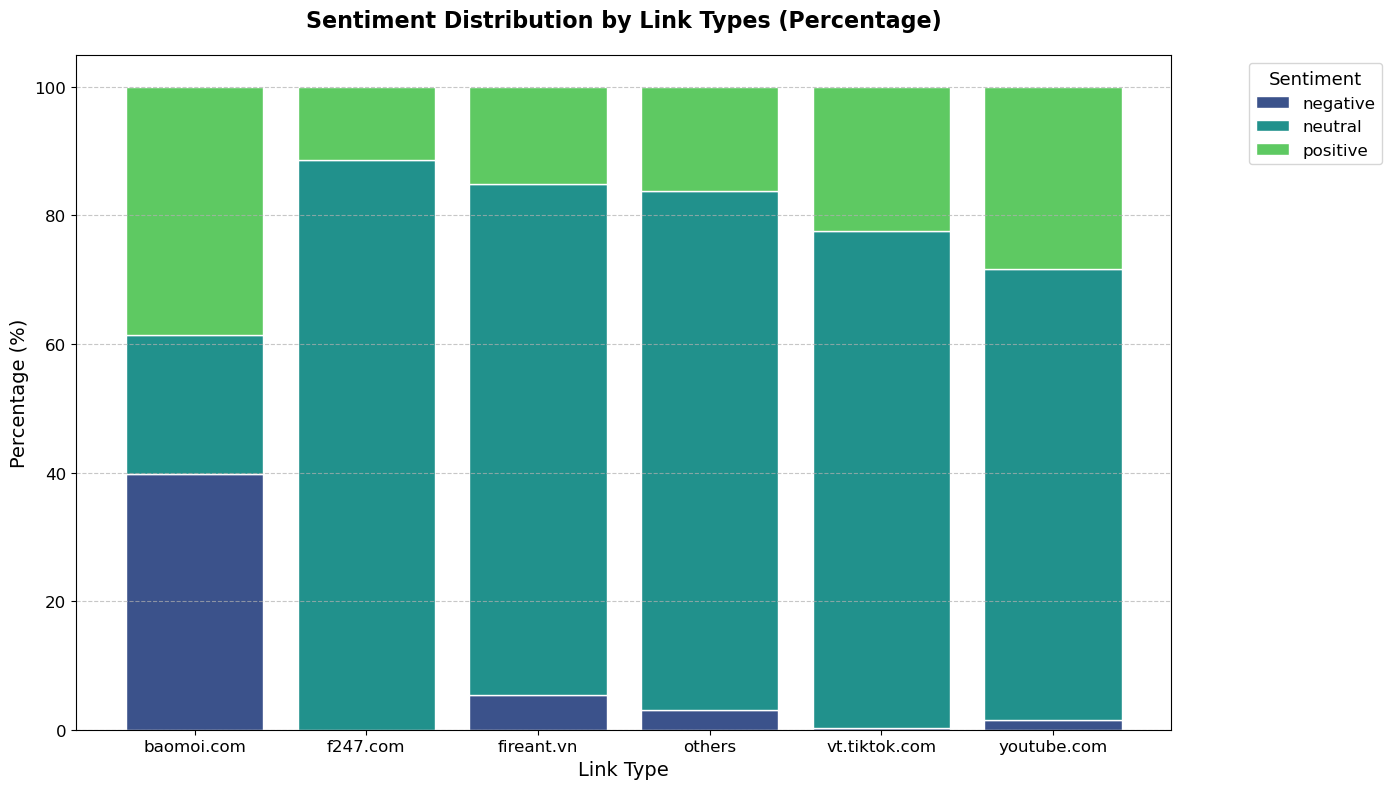

In [15]:
# Chuẩn bị dữ liệu
link_sentiment_correlation = links_df.pivot_table(index='link_type', columns='sentiment', aggfunc='size', fill_value=0)
link_sentiment_correlation_percentage = link_sentiment_correlation.div(link_sentiment_correlation.sum(axis=1), axis=0) * 100  # Chuẩn hóa tỷ lệ %
link_sentiment_correlation_percentage = link_sentiment_correlation_percentage.reset_index()

# Vẽ biểu đồ bar chart dạng tỷ lệ phần trăm
plt.figure(figsize=(14, 8))
bar_width = 0.8
bottom_values = pd.Series(0, index=link_sentiment_correlation_percentage.index)

colors = sns.color_palette("viridis", n_colors=len(link_sentiment_correlation_percentage.columns) - 1)
for i, sentiment in enumerate(link_sentiment_correlation_percentage.columns[1:]):  # Bỏ cột 'link_type'
    plt.bar(
        link_sentiment_correlation_percentage['link_type'],
        link_sentiment_correlation_percentage[sentiment],
        bottom=bottom_values,
        label=sentiment,
        color=colors[i],
        edgecolor='white',
        width=bar_width
    )
    # Cập nhật giá trị bottom
    bottom_values += link_sentiment_correlation_percentage[sentiment]

# Cài đặt tiêu đề và nhãn
plt.title('Sentiment Distribution by Link Types (Percentage)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Link Type', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Thêm chú thích
plt.legend(title="Sentiment", title_fontsize=13, fontsize=12, loc='upper right', bbox_to_anchor=(1.2, 1))

# Thêm gridline nhẹ
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Nhận thấy ta có thể phân tích tỉ lệ 3 sentiment của các `link_type`. Từ đó lựa chọn heatmap để thể hiện.

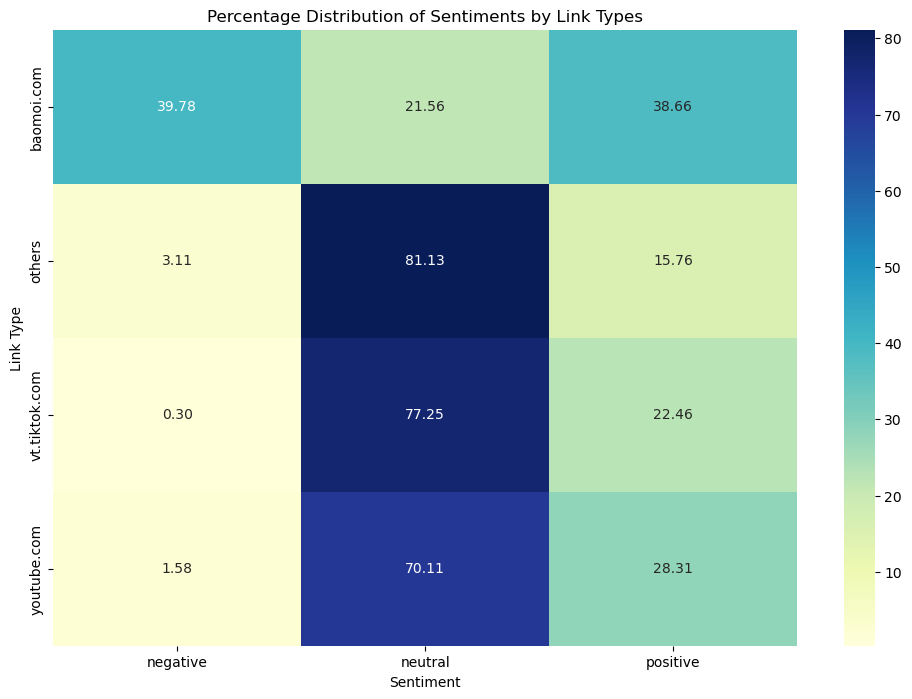

In [16]:
top_4_links = link_type_counts['link_type'][:4].tolist()

# Thay thế các loại link ít phổ biến bằng 'others'
links_df['link_type'] = links_df['link_type'].apply(lambda x: x if x in top_4_links else 'others')

# Tạo bảng tương quan giữa các loại liên kết và sentiment
link_correlation = links_df.pivot_table(index='link_type', columns='sentiment', aggfunc='size', fill_value=0)

# Tính tỷ lệ phần trăm
link_correlation_percentage = link_correlation.div(link_correlation.sum(axis=1), axis=0) * 100

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.heatmap(link_correlation_percentage, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Percentage Distribution of Sentiments by Link Types')
plt.xlabel('Sentiment')
plt.ylabel('Link Type')
plt.show()

Từ `Sentiment Distribution by Link Types` và `Percentage Distribution of Sentiments by Link Types`, có thể nhận xét như sau:

1. **Youtube.com**: Đây là loại liên kết phổ biến nhất và có sự phân bố đều giữa các loại sentiment. Đặc biệt, số lượng liên kết có sentiment tích cực (positive) và trung lập (neutral) chiếm ưu thế hơn so với tiêu cực (negative).

2. **Vt.tiktok.com**: Loại liên kết này chủ yếu có sentiment trung lập và tích cực, với số lượng sentiment trung lập chiếm phần lớn.

3. **Baomoi.com**: Số lượng liên kết từ baomoi.com có sentiment tiêu cực và tích cực gần như tương đương, trong khi sentiment trung lập ít hơn.

4. **Fireant.vn**: Loại liên kết này chủ yếu có sentiment trung lập, với số lượng sentiment tiêu cực và tích cực ít hơn.

5. **Others**: Các liên kết khác ngoài top 4 chủ yếu có sentiment trung lập, nhưng cũng có một số lượng đáng kể sentiment tích cực và tiêu cực.

Nhìn chung, các liên kết từ youtube.com và vt.tiktok.com và fireant.vn có xu hướng mang lại sentiment tích cực và trung lập nhiều hơn, trong khi các liên kết từ baomoi.com có sự phân bố sentiment đa dạng hơn.

phân tích độ liên kết của linktype và chỉ số thị trường như VNINDEX, VN30, HNINDEX, UPCOM

có thể là thời điểm số lần linktype ( cột ) xuất hiện và chỉ số VNINDEX như nào ( dạng line )

In [17]:
# Chuyển đổi cột 'date' sang định dạng datetime
links_df['date'] = pd.to_datetime(links_df['date'], format='ISO8601')

# Tôi cần 1 df biểu diễn số lần link_type xuất hiện theo ngày
link_type_counts_by_date = links_df.groupby([pd.Grouper(key='date', freq='D'), 'link_type']).size().reset_index()
link_type_counts_by_date.columns = ['date', 'link_type', 'count']

# Định dạng lại cột 'date'
link_type_counts_by_date['date'] = link_type_counts_by_date['date'].dt.strftime('%Y-%m-%d')

link_type_counts_by_date


,date,link_type,count
0,2024-09-06,baomoi.com,1
1,2024-09-06,others,28
2,2024-09-06,vt.tiktok.com,4
3,2024-09-06,youtube.com,77
4,2024-09-07,others,12
...,...,...,...
241,2024-11-05,youtube.com,167
242,2024-11-06,baomoi.com,2
243,2024-11-06,others,39
244,2024-11-06,vt.tiktok.com,8


In [18]:
# tạo total_link_count_by_date
total_link_counts_by_date = link_type_counts_by_date.groupby('date')['count'].sum().reset_index()


In [19]:
# Đọc dữ liệu từ csv trong folder price
vnindex_prices = pd.read_csv('price/VNINDEX.csv')
vn30_prices = pd.read_csv('price/VN30.csv')
hnxindex_prices = pd.read_csv('price/HNXINDEX.csv')

# Chuyển cột 'date' sang định dạng datetime
vn30_prices['time'] = pd.to_datetime(vn30_prices['time'], format='%Y-%m-%d %H:%M:%S')
hnxindex_prices['time'] = pd.to_datetime(hnxindex_prices['time'], format='%Y-%m-%d %H:%M:%S')
vnindex_prices['time'] = pd.to_datetime(vnindex_prices['time'], format='%Y-%m-%d %H:%M:%S')

In [20]:
# Tạo dataframe mới chứa ngày và giá trị lớn nhất của volume của VN30, VNINDEX, HNXINDEX
total_volume_by_date_vn30 = vn30_prices.groupby(vn30_prices['time'].dt.date)['volume'].sum().reset_index()
total_volume_by_date_vnindex = vnindex_prices.groupby(vnindex_prices['time'].dt.date)['volume'].sum().reset_index()
total_volume_by_date_hnxindex = hnxindex_prices.groupby(hnxindex_prices['time'].dt.date)['volume'].sum().reset_index()

# Đổi tên các cột cho dễ hiểu
total_volume_by_date_vn30.columns = ['date', 'max_volume_vn30']
total_volume_by_date_vnindex.columns = ['date', 'max_volume_vnindex']
total_volume_by_date_hnxindex.columns = ['date', 'max_volume_hnxindex']

# Gộp các dataframe lại với nhau
total_volume_by_date_all = total_volume_by_date_vn30.merge(total_volume_by_date_vnindex, on='date').merge(total_volume_by_date_hnxindex, on='date')

total_volume_by_date_all

,date,max_volume_vn30,max_volume_vnindex,max_volume_hnxindex
0,2024-09-04,229581631,637198624,48459300
1,2024-09-05,272533061,660978986,42886200
2,2024-09-06,286314832,621685618,43256400
3,2024-09-09,177611343,492276545,52085200
4,2024-09-10,274793462,684988153,51372100
5,2024-09-11,171434968,577336572,38562700
6,2024-09-12,158340731,425404900,34326000
7,2024-09-13,174551693,475891982,43438200
8,2024-09-16,243225247,602932144,39363000
9,2024-09-17,232292166,627862732,44984200


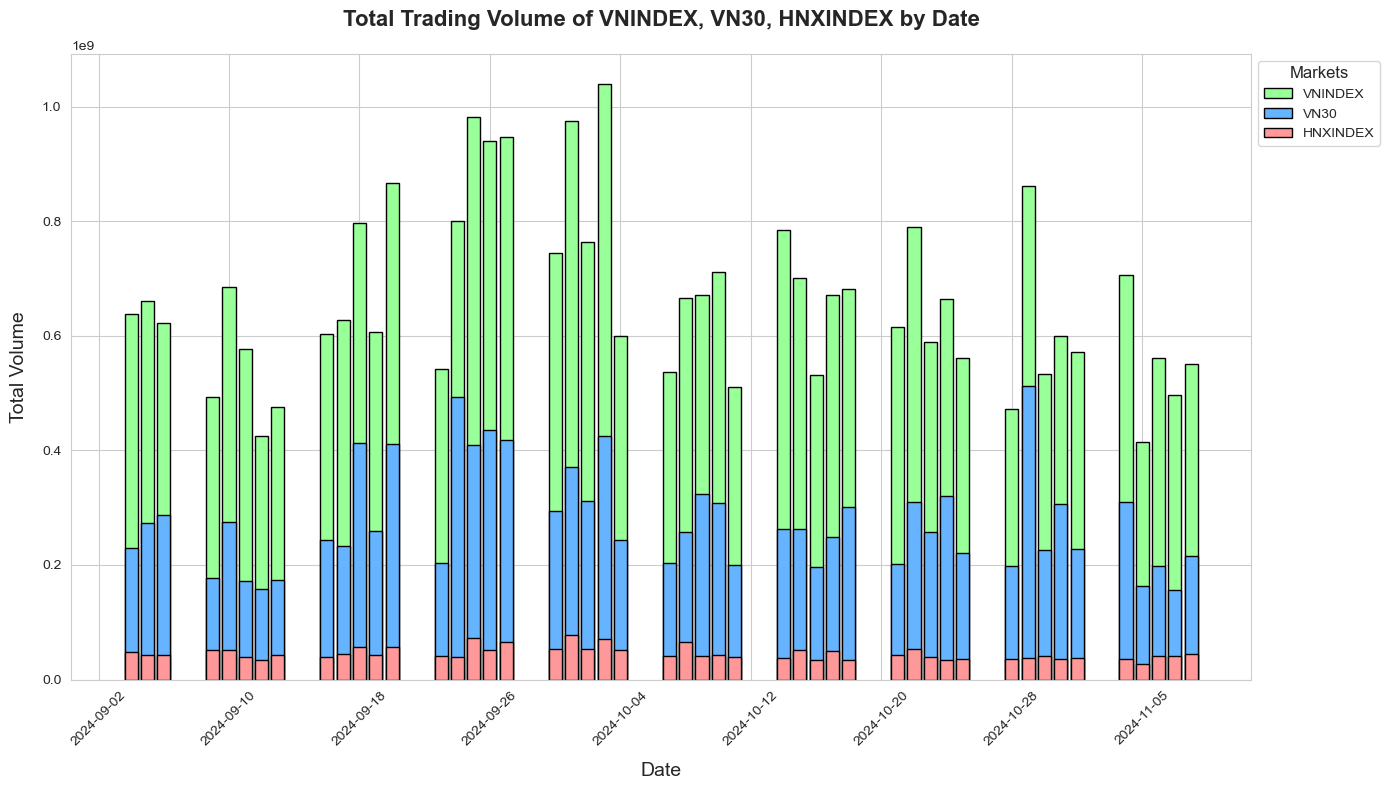

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập bảng màu
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Vẽ biểu đồ cột chồng (stacked bar chart)
plt.figure(figsize=(14, 8))

# Biểu đồ chồng cột
plt.bar(
    total_volume_by_date_all['date'],
    total_volume_by_date_all['max_volume_vnindex'],
    label='VNINDEX',
    color='#99ff99',  # Màu pastel xanh lá
    edgecolor='black',
)
plt.bar(
    total_volume_by_date_all['date'],
    total_volume_by_date_all['max_volume_vn30'],
    label='VN30',
    color='#66b3ff',  # Màu pastel xanh nhạt
    edgecolor='black',
)
plt.bar(
    total_volume_by_date_all['date'],
    total_volume_by_date_all['max_volume_hnxindex'],
    label='HNXINDEX',
    color='#ff9999',  # Màu pastel đỏ nhạt
    edgecolor='black',
)



# Thiết lập nhãn và tiêu đề
plt.title('Total Trading Volume of VNINDEX, VN30, HNXINDEX by Date', fontsize=16, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Total Volume', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Tăng số lượng nhãn trên trục x (lấy tối đa 10 nhãn)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

# Thêm chú thích và tinh chỉnh vị trí
plt.legend(title="Markets", title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Tăng khoảng cách giữa các thành phần
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()



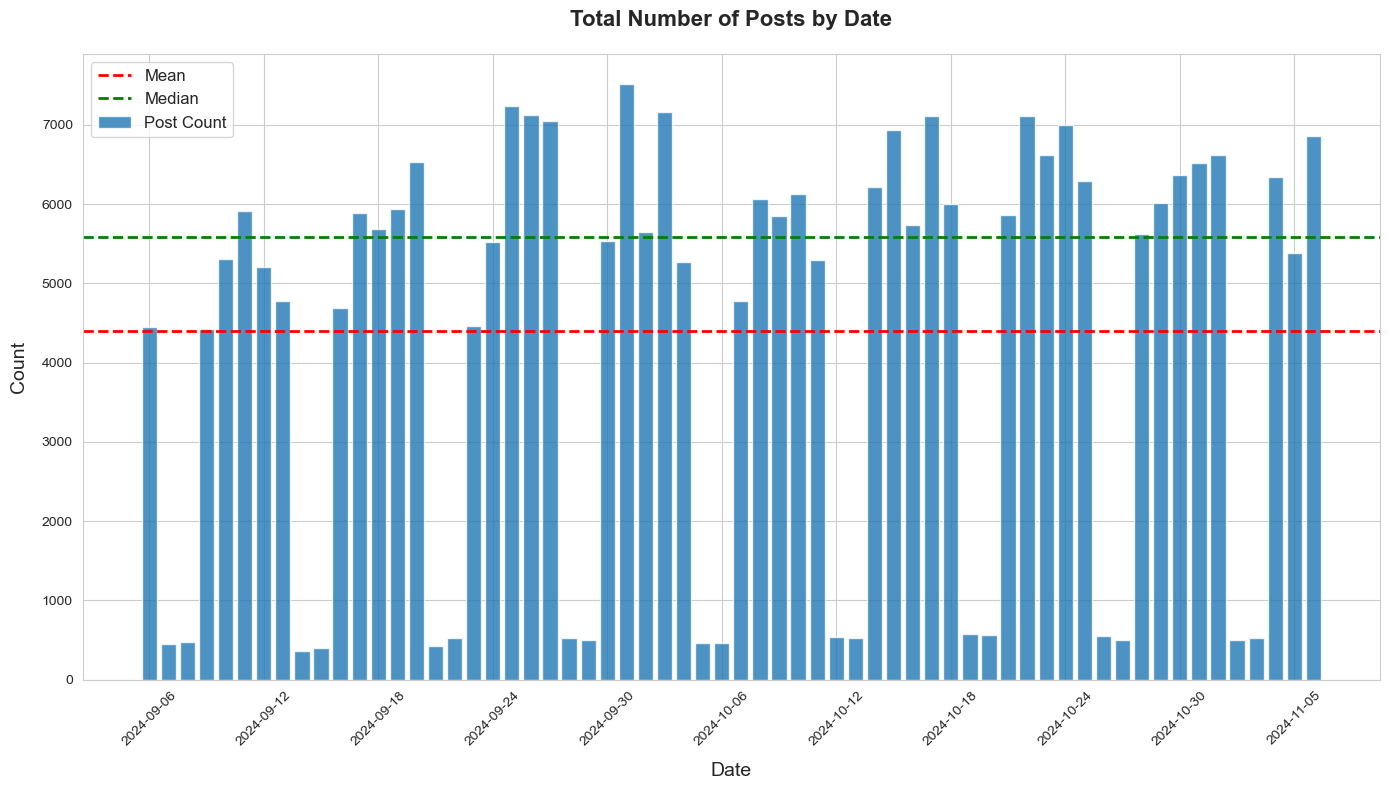

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chuyển đổi cột 'date' sang định dạng datetime nếu chưa được chuyển đổi
posts_df['date'] = pd.to_datetime(posts_df['date'], format='ISO8601')

# Tạo ra post_counts_by_date để tính số bài viết trong ngày
post_counts_by_date = posts_df.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
post_counts_by_date.columns = ['date', 'post_count']
post_counts_by_date['date'] = post_counts_by_date['date'].dt.strftime('%Y-%m-%d')

median_value = post_counts_by_date['post_count'].median()
mean_value = post_counts_by_date['post_count'].mean()

# Thiết lập bảng màu và phong cách
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Vẽ biểu đồ dạng cột
plt.figure(figsize=(14, 8))
plt.bar(post_counts_by_date['date'], post_counts_by_date['post_count'], color='#1f77b4', alpha=0.8, label='Post Count')
plt.axhline(y=mean_value, color='red', linestyle='--', linewidth=2, label='Mean')
# Thêm đường biểu diễn giá trị trung vị
plt.axhline(y=median_value, color='green', linestyle='--', linewidth=2, label='Median')

# Thêm nhãn và chú thích
plt.title('Total Number of Posts by Date', fontsize=16, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(ticks=np.arange(0, len(post_counts_by_date['date']), max(1, len(post_counts_by_date['date']) // 10)), 
           labels=post_counts_by_date['date'][::max(1, len(post_counts_by_date['date']) // 10)], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left')

# Tăng khoảng cách và hiển thị biểu đồ
plt.tight_layout()
plt.show()


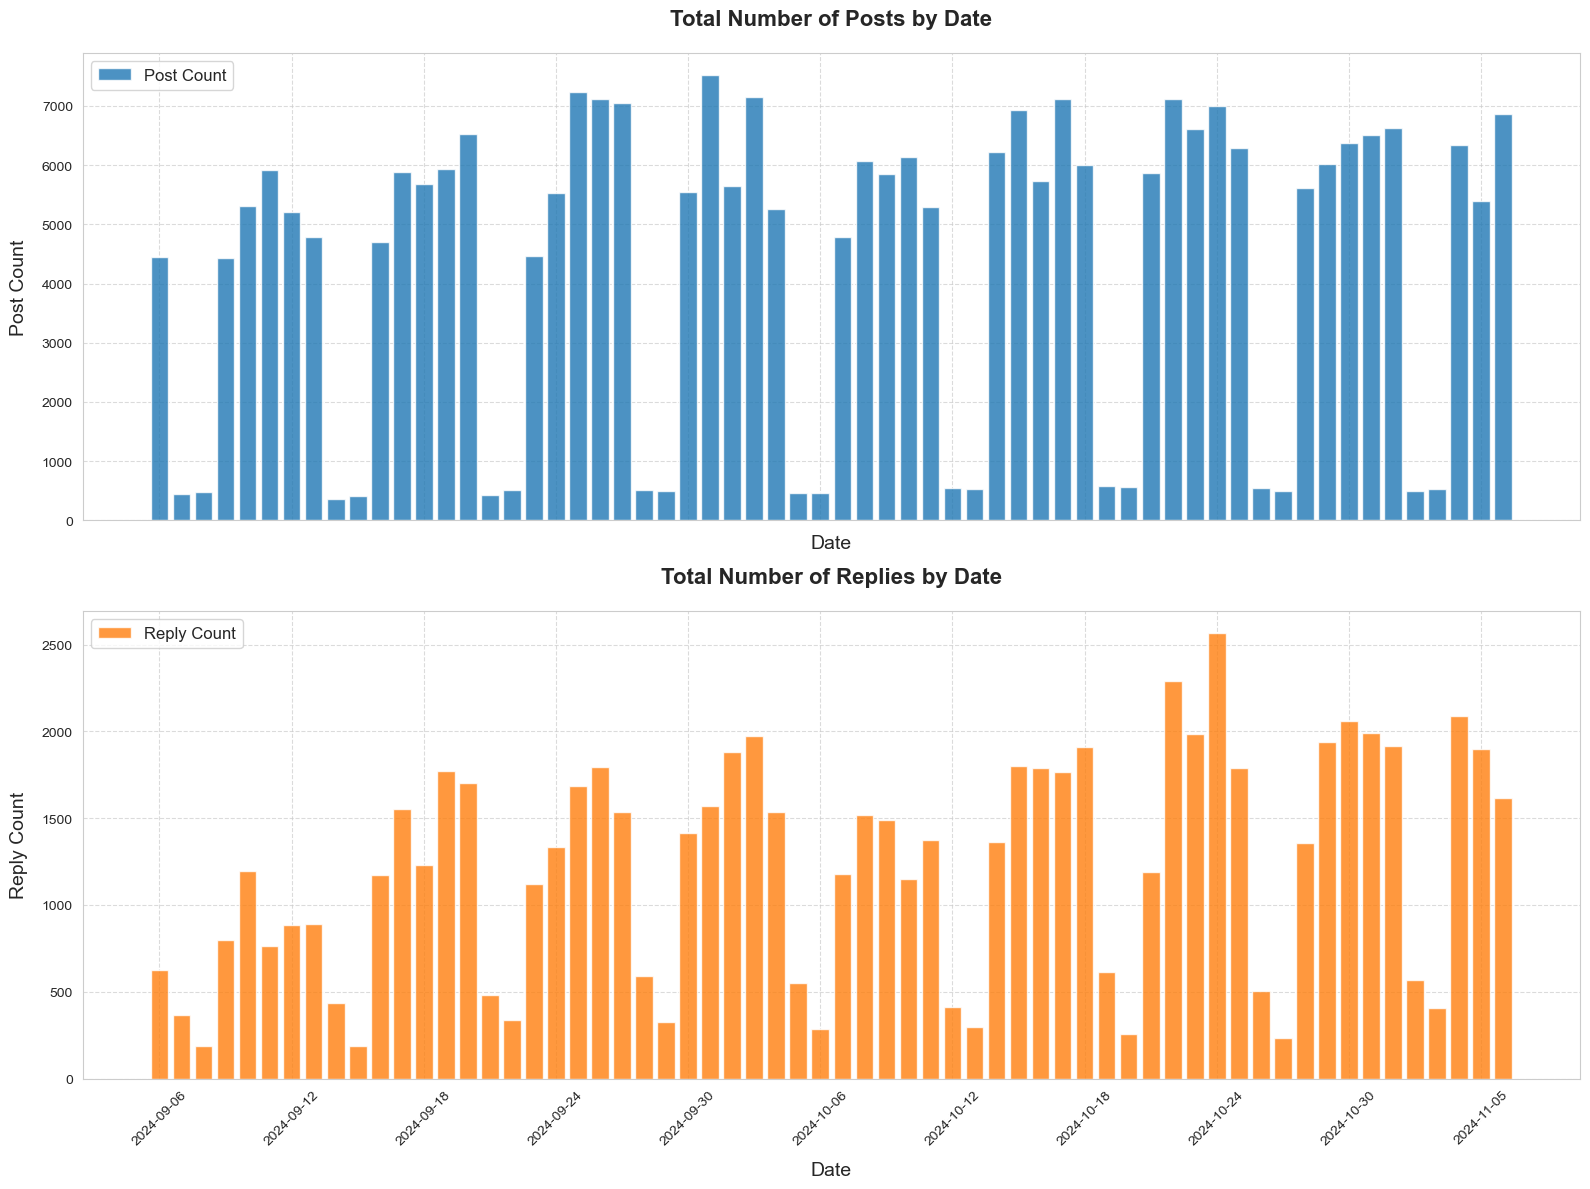

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển đổi cột 'date' sang định dạng datetime nếu chưa được chuyển đổi
posts_df['date'] = pd.to_datetime(posts_df['date'], format='ISO8601')
replies_df['date'] = pd.to_datetime(replies_df['date'], format='ISO8601')

# Tạo dataframe số lượng bài viết và phản hồi theo ngày
post_counts_by_date = posts_df.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
post_counts_by_date.columns = ['date', 'post_count']
post_counts_by_date['date'] = post_counts_by_date['date'].dt.strftime('%Y-%m-%d')

reply_counts_by_date = replies_df.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
reply_counts_by_date.columns = ['date', 'reply_count']
reply_counts_by_date['date'] = reply_counts_by_date['date'].dt.strftime('%Y-%m-%d')

# Thiết lập bảng màu và phong cách chung
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Tạo figure cho dashboard
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Biểu đồ 1: Số bài viết theo ngày
axes[0].bar(post_counts_by_date['date'], post_counts_by_date['post_count'], color='#1f77b4', alpha=0.8, label='Post Count')
axes[0].set_title('Total Number of Posts by Date', fontsize=16, weight='bold', pad=20)
axes[0].set_xlabel('Date', fontsize=14, labelpad=10)
axes[0].set_ylabel('Post Count', fontsize=14, labelpad=10)
axes[0].legend(fontsize=12, loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Biểu đồ 2: Số phản hồi theo ngày
axes[1].bar(reply_counts_by_date['date'], reply_counts_by_date['reply_count'], color='#ff7f0e', alpha=0.8, label='Reply Count')
axes[1].set_title('Total Number of Replies by Date', fontsize=16, weight='bold', pad=20)
axes[1].set_xlabel('Date', fontsize=14, labelpad=10)
axes[1].set_ylabel('Reply Count', fontsize=14, labelpad=10)
axes[1].legend(fontsize=12, loc='upper left')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Cài đặt nhãn trục x
axes[1].set_xticks(ticks=np.arange(0, len(post_counts_by_date['date']), max(1, len(post_counts_by_date['date']) // 10)))
axes[1].set_xticklabels(post_counts_by_date['date'][::max(1, len(post_counts_by_date['date']) // 10)], rotation=45, fontsize=10)
axes[0].set_xticks(ticks=np.arange(0, len(reply_counts_by_date['date']), max(1, len(reply_counts_by_date['date']) // 10)))
axes[0].set_xticklabels(reply_counts_by_date['date'][::max(1, len(reply_counts_by_date['date']) // 10)], rotation=45, fontsize=10)
# Tăng khoảng cách giữa các biểu đồ
plt.tight_layout()

# Hiển thị dashboard
plt.show()


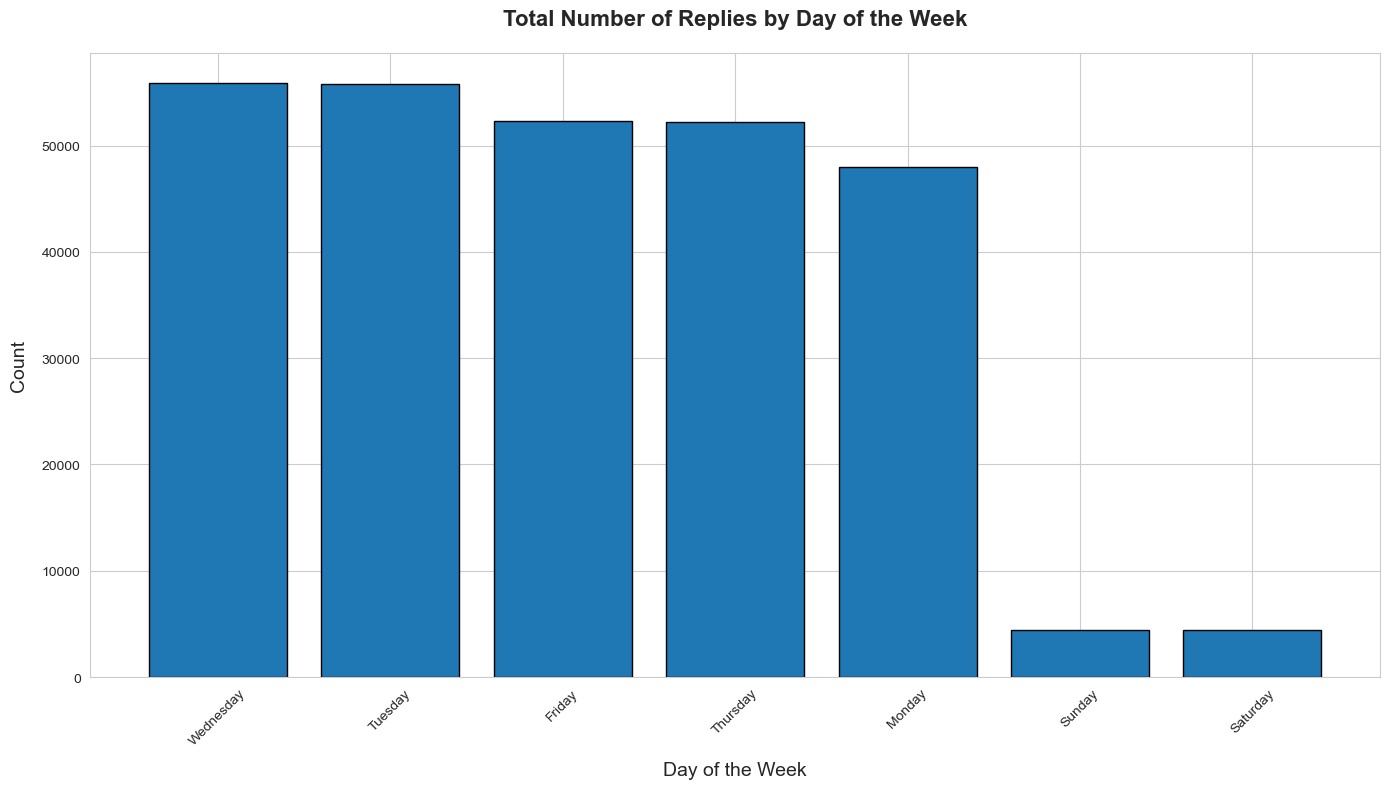

In [24]:
# Tạo column chart cho số lượng bài viết theo thứ trong tuần
posts_df['day_of_week'] = posts_df['date'].dt.day_name()
posts_df['day_of_week'] = pd.Categorical(posts_df['day_of_week'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
posts_by_day = posts_df['day_of_week'].value_counts().reset_index()
posts_by_day.columns = ['day_of_week', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
plt.bar(posts_by_day['day_of_week'], posts_by_day['count'], color='#1f77b4', edgecolor='black')

# Thêm nhãn và chú thích
plt.title('Total Number of Replies by Day of the Week', fontsize=16, weight='bold', pad=20)
plt.xlabel('Day of the Week', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


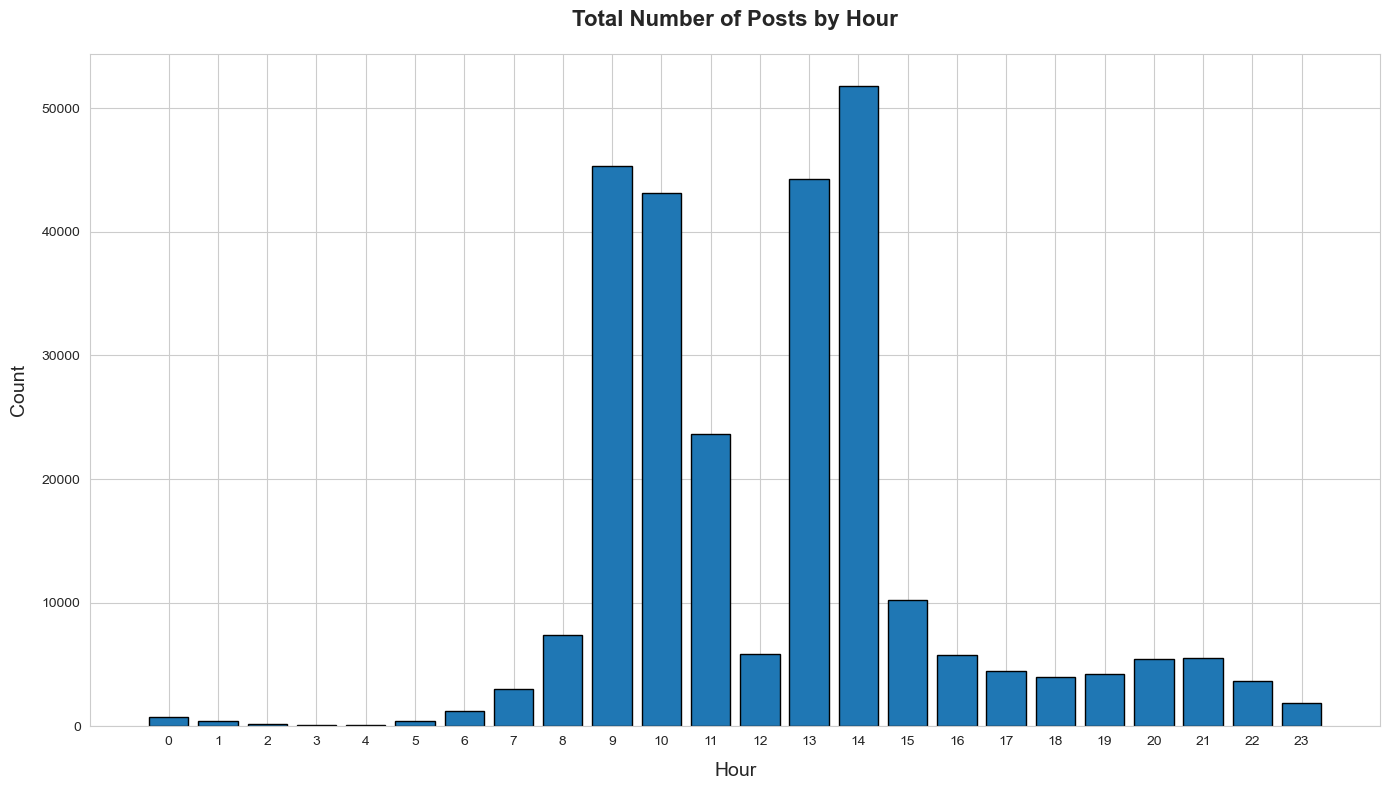

11374.125

In [25]:
# Tạo column chart cho số lượng bài viết theo giờ.
post_counts_by_hour = posts_df.groupby(posts_df['date'].dt.hour).size().reset_index()
post_counts_by_hour.columns = ['hour', 'post_count']

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
plt.bar(post_counts_by_hour['hour'], post_counts_by_hour['post_count'], color='#1f77b4', edgecolor='black')

# Thêm nhãn và chú thích
plt.title('Total Number of Posts by Hour', fontsize=16, weight='bold', pad=20)
plt.xlabel('Hour', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(post_counts_by_hour['hour'], fontsize=10)
plt.yticks(fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

# in ra trung bình số bài viết theo giờ
post_counts_by_hour['post_count'].mean()



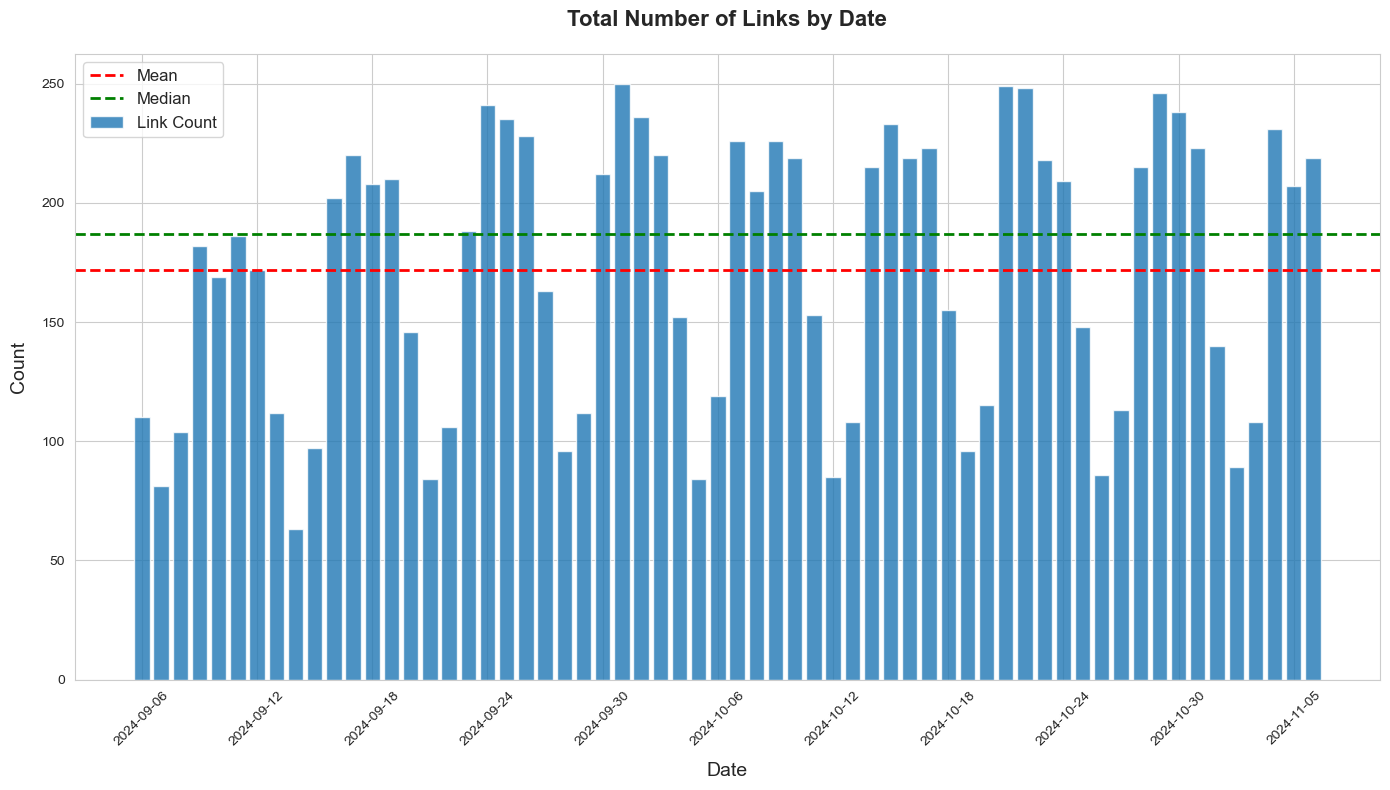

In [55]:
# tạo ra link_type_counts_by_date
link_type_counts_by_date = links_df.groupby([pd.Grouper(key='date', freq='D')]).size().reset_index(name='count')
link_type_counts_by_date['date'] = link_type_counts_by_date['date'].dt.strftime('%Y-%m-%d')
link_mean_value = link_type_counts_by_date['count'].mean()
link_median_value = link_type_counts_by_date['count'].median()


from scipy.interpolate import make_interp_spline

# Thiết lập bảng màu và phong cách
sns.set_palette("pastel")
sns.set_style("whitegrid")

# Vẽ biểu đồ dạng cột
plt.figure(figsize=(14, 8))
plt.bar(link_type_counts_by_date['date'], link_type_counts_by_date['count'], color='#1f77b4', alpha=0.8, label='Link Count')

plt.axhline(y=link_mean_value, color='red', linestyle='--', linewidth=2, label='Mean')
# Thêm đường biểu diễn giá trị trung vị

plt.axhline(y=link_median_value, color='green', linestyle='--', linewidth=2, label='Median')

# Thêm nhãn và chú thích
plt.title('Total Number of Links by Date', fontsize=16, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(ticks=np.arange(0, len(link_type_counts_by_date['date']), max(1, len(link_type_counts_by_date['date']) // 10)), 
           labels=link_type_counts_by_date['date'][::max(1, len(link_type_counts_by_date['date']) // 10)], rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left')

# Tăng khoảng cách và hiển thị biểu đồ
plt.tight_layout()
plt.show()



Nhận thấy có vẻ số lần xuất hiện link có tương quan rất lớn với lượng giao dịch cổ phiếu.

### Khi số lượng link được đề cập tăng (đặc biệt nếu là các tin tức quan trọng), khối lượng giao dịch có thể tăng do:

1. *Nhà đầu tư chú ý và phản ứng với thông tin.*

2. *Sự kiện thu hút dòng vốn mới vào cổ phiếu liên quan.*

### **Ngược lại**, nếu một cổ phiếu ít được chú ý (số lượng link ít), khả năng khối lượng giao dịch sẽ thấp do sự quan tâm ít hơn.

### Giả thuyết:
Số lượng link được đề cập có tương quan thuận với khối lượng giao dịch của cổ phiếu.

### Cách chứng minh giả thuyết:
1. **Thu thập dữ liệu**: Sử dụng dữ liệu từ `links_df` để lấy số lượng link được đề cập theo ngày và dữ liệu từ `total_volume_by_date_all` để lấy khối lượng giao dịch theo ngày.

2. **Tính toán tương quan**: Sử dụng hệ số tương quan Pearson để đo lường mức độ tương quan giữa số lượng link và khối lượng giao dịch.

3. **Trực quan hóa dữ liệu**: Vẽ biểu đồ đường (line chart) để so sánh xu hướng của số lượng link và khối lượng giao dịch theo thời gian.

4. **Phân tích kết quả**: Đánh giá hệ số tương quan và biểu đồ để xác định xem có mối quan hệ rõ ràng giữa số lượng link và khối lượng giao dịch hay không.

### Mã Python để chứng minh giả thuyết:

In [27]:

# Chuyển đổi cột 'date' thành định dạng datetime nếu chưa được chuyển đổi
total_link_counts_by_date['date'] = pd.to_datetime(total_link_counts_by_date['date'])
total_volume_by_date_all['date'] = pd.to_datetime(total_volume_by_date_all['date'])

# Hợp nhất hai DataFrame dựa trên cột 'date'
merged_df = pd.merge(total_link_counts_by_date, total_volume_by_date_all, on='date')
# Tính toán hệ số tương quan Pearson giữa 'count' và 'max_volume_vnindex'
correlation_vnindex, _ = pearsonr(merged_df['count'], merged_df['max_volume_vnindex'])
print('hệ số tương quan Pearson giữa count và max_volume_vnindex :', correlation_vnindex)

# Tính toán hệ số tương quan Pearson giữa 'count' và 'max_volume_vn30'
correlation_vn30, _ = pearsonr(merged_df['count'], merged_df['max_volume_vn30'])
print('hệ số tương quan Pearson giữa count và max_volume_vn30 :', correlation_vn30)

# Tính toán hệ số tương quan Pearson giữa 'count' và 'max_volume_hnxindex'
correlation_hnxindex, _ = pearsonr(merged_df['count'], merged_df['max_volume_hnxindex'])
print('hệ số tương quan Pearson giữa count và max_volume_hnxindex :', correlation_hnxindex)

# Tính toán hệ số tương quan Pearson giữa 'count' và tổng khối lượng giao dịch của cả 3 mã
merged_df['total_volume'] = merged_df['max_volume_vnindex'] + merged_df['max_volume_vn30'] + merged_df['max_volume_hnxindex']
correlation_total_volume, _ = pearsonr(merged_df['count'], merged_df['total_volume'])
print('Hệ số tương quan Pearson giữa count và tổng khối lượng giao dịch của cả 3 mã:', correlation_total_volume)


hệ số tương quan Pearson giữa count và max_volume_vnindex : 0.3257006135139205
hệ số tương quan Pearson giữa count và max_volume_vn30 : 0.28806849536558565
hệ số tương quan Pearson giữa count và max_volume_hnxindex : 0.12516051080864538
Hệ số tương quan Pearson giữa count và tổng khối lượng giao dịch của cả 3 mã: 0.31707887701441095


ko ổn :)))))

In [28]:
# Chuyển đổi cột 'date' thành định dạng datetime nếu chưa được chuyển đổi
post_counts_by_date['date'] = pd.to_datetime(post_counts_by_date['date'])
total_volume_by_date_all['date'] = pd.to_datetime(total_volume_by_date_all['date'])

# Hợp nhất hai DataFrame dựa trên cột 'date'
merged_post_volume_df = pd.merge(post_counts_by_date, total_volume_by_date_all, on='date')
# Tính toán hệ số tương quan Pearson giữa 'count' và 'max_volume_vnindex'
correlation_vnindex, _ = pearsonr(merged_post_volume_df['post_count'], merged_post_volume_df['max_volume_vnindex'])
print('hệ số tương quan Pearson giữa count và max_volume_vnindex :', correlation_vnindex)

# Tính toán hệ số tương quan Pearson giữa 'count' và 'max_volume_vn30'
correlation_vn30, _ = pearsonr(merged_post_volume_df['post_count'], merged_post_volume_df['max_volume_vn30'])
print('hệ số tương quan Pearson giữa count và max_volume_vn30 :', correlation_vn30)

# Tính toán hệ số tương quan Pearson giữa 'count' và 'max_volume_hnxindex'
correlation_hnxindex, _ = pearsonr(merged_post_volume_df['post_count'], merged_post_volume_df['max_volume_hnxindex'])
print('hệ số tương quan Pearson giữa count và max_volume_hnxindex :', correlation_hnxindex)

# Tính toán hệ số tương quan Pearson giữa 'count' và tổng khối lượng giao dịch của cả 3 mã
merged_post_volume_df['total_volume'] = merged_post_volume_df['max_volume_vnindex'] + merged_post_volume_df['max_volume_vn30'] + merged_post_volume_df['max_volume_hnxindex']
correlation_total_volume, _ = pearsonr(merged_post_volume_df['post_count'], merged_post_volume_df['total_volume'])
print('Hệ số tương quan Pearson giữa count và tổng khối lượng giao dịch của cả 3 mã:', correlation_total_volume)

hệ số tương quan Pearson giữa count và max_volume_vnindex : 0.6057876267247609
hệ số tương quan Pearson giữa count và max_volume_vn30 : 0.44704638309020067
hệ số tương quan Pearson giữa count và max_volume_hnxindex : 0.3942607881766281
Hệ số tương quan Pearson giữa count và tổng khối lượng giao dịch của cả 3 mã: 0.5644390093656052


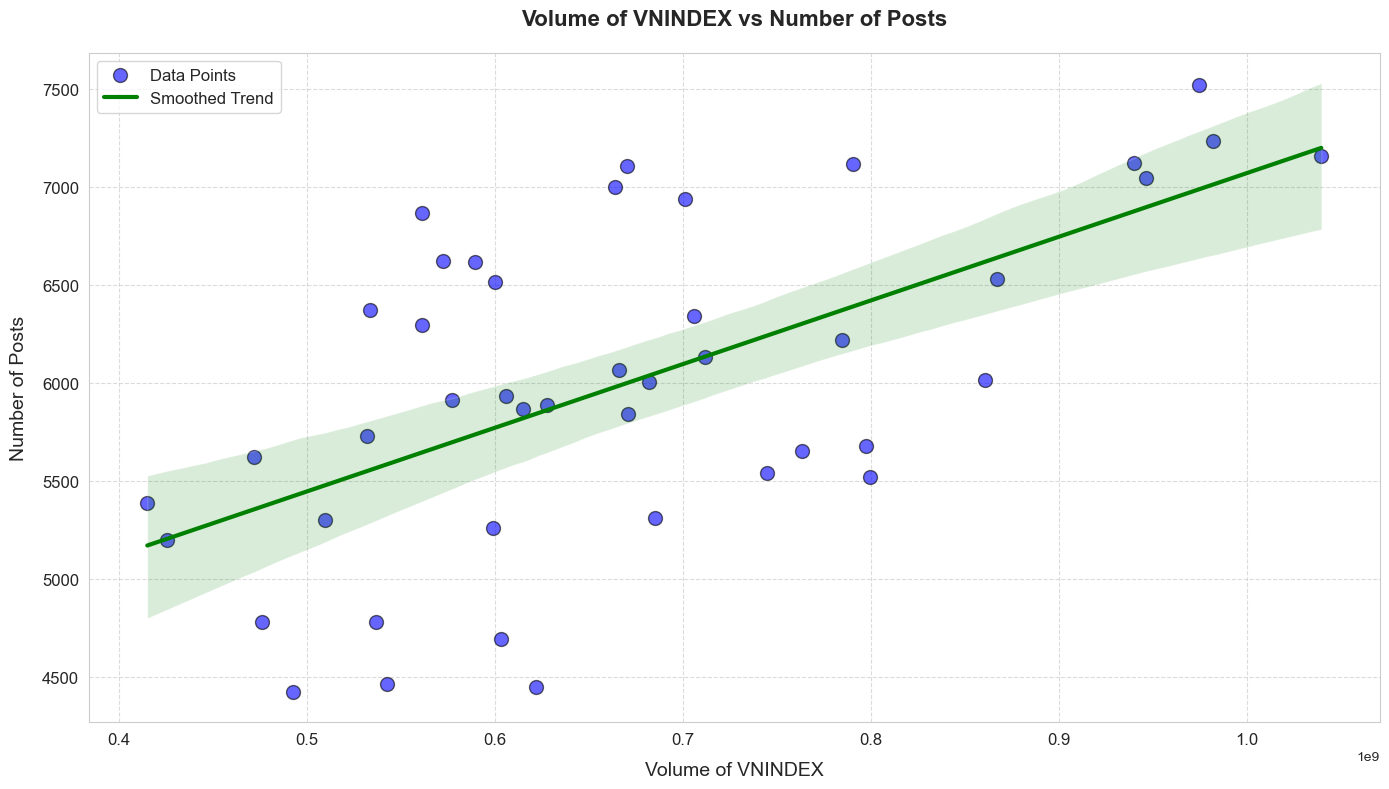

In [29]:
from scipy.stats import linregress

# Tạo scatter plot với đường xu hướng mịn
plt.figure(figsize=(14, 8))

# Scatter plot
plt.scatter(merged_post_volume_df['max_volume_vnindex'], merged_post_volume_df['post_count'], 
            color='b', alpha=0.6, edgecolor='k', s=100, label='Data Points')

# Vẽ đường xu hướng mịn sử dụng Seaborn
sns.regplot(x='max_volume_vnindex', y='post_count', data=merged_post_volume_df, 
            scatter=False, color='g', 
            line_kws={'linewidth': 3}, label='Smoothed Trend')

# Tùy chỉnh thông tin biểu đồ
plt.title('Volume of VNINDEX vs Number of Posts', fontsize=16, weight='bold', pad=20)
plt.xlabel('Volume of VNINDEX', fontsize=14, labelpad=10)
plt.ylabel('Number of Posts', fontsize=14, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

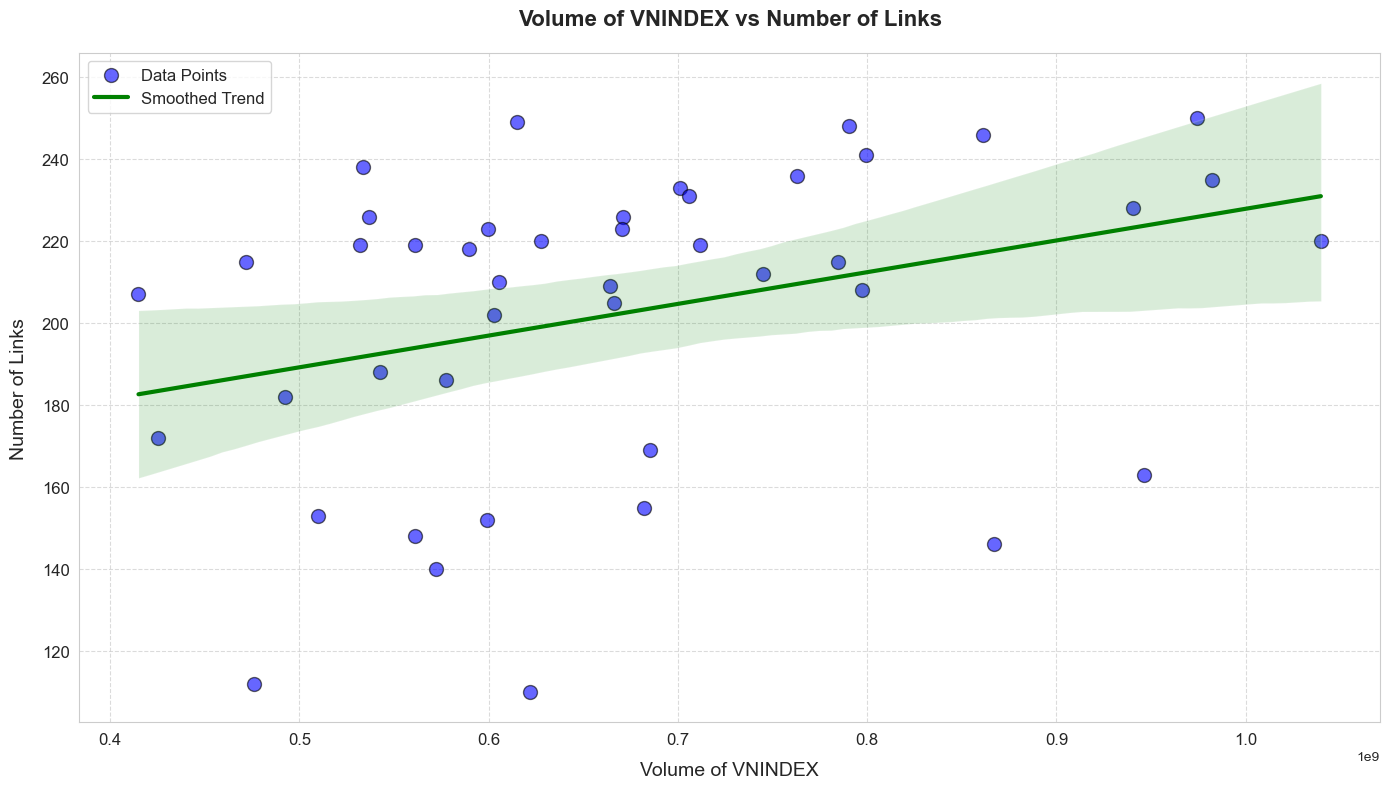

In [30]:
from scipy.stats import linregress

# Tạo scatter plot với đường xu hướng mịn
plt.figure(figsize=(14, 8))

# Scatter plot
plt.scatter(merged_df['max_volume_vnindex'], merged_df['count'], 
            color='b', alpha=0.6, edgecolor='k', s=100, label='Data Points')

# Vẽ đường xu hướng mịn sử dụng Seaborn
sns.regplot(x='max_volume_vnindex', y='count', data=merged_df, 
            scatter=False, color='g', 
            line_kws={'linewidth': 3}, label='Smoothed Trend')

# Tùy chỉnh thông tin biểu đồ
plt.title('Volume of VNINDEX vs Number of Links', fontsize=16, weight='bold', pad=20)
plt.xlabel('Volume of VNINDEX', fontsize=14, labelpad=10)
plt.ylabel('Number of Links', fontsize=14, labelpad=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


#### 3. Phân tích mỗi tương quan của sự tương tác trên bài viết và các yếu tố khác.

In [31]:
# Tạo một dataframe mới chứa các bài viết, độ dài bài viết, tổng lượt like, tổng lượt phản hồi, sentiment, các mã chứng khoán đề cập
posts_summary = posts_df.loc[:, ['date', 'postID', 'originalContent', 'sentiment', 'taggedSymbols']]
posts_summary['post_length'] = posts_summary['originalContent'].apply(lambda x: len(x))
posts_summary['total_likes'] = posts_df['totalLikes']
posts_summary['total_replies'] = posts_df['totalReplies']

# Săp xếp dataframe theo số lượng lượt like giảm dần
posts_summary = posts_summary.sort_values(by='total_likes', ascending=False).reset_index(drop=True)
posts_summary.head(20)

# Nhận thấy các bài viết tổng hợp của ngày là những bài có lượng tương tác cao, và lượt bình luận cao.

,date,postID,originalContent,sentiment,taggedSymbols,post_length,total_likes,total_replies
0,2024-10-24 15:19:54.307000+07:00,28869167,Phái Sinh ngày 24/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42514.95}, {""symb"":...",836,69,125
1,2024-09-26 20:35:36.153000+07:00,28352578,XU HƯỚNG TTCK QUÝ 4. 2024\n\nĐể xác định xu hư...,neutral,"[{""symb"": ""^DJI"", ""price"": 42166.66}, {""symb"":...",5785,68,15
2,2024-10-28 15:21:13.823000+07:00,28923357,Phái Sinh ngày 28/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42114.4}, {""symb"": ...",839,63,64
3,2024-10-22 19:47:48.227000+07:00,28821151,Hy vọng năm sau tôi và các bạn sẽ cùng nhau cổ...,neutral,"[{""symb"": ""BSR"", ""price"": 21.3}, {""symb"": ""DXG...",5372,62,31
4,2024-10-03 15:27:47.050000+07:00,28483887,Phái Sinh ngày 3/10/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""$BTC"", ""price"": 61459.01}, {""symb"":...",774,62,151
5,2024-10-22 15:19:18.600000+07:00,28817167,Phái Sinh ngày 22/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42931.6}, {""symb"": ...",836,62,93
6,2024-09-17 15:26:44.700000+07:00,28172493,Phái Sinh ngày 17/9/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 41622.08}, {""symb"":...",926,61,76
7,2024-10-15 15:21:31.533000+07:00,28687978,Phái Sinh ngày 15/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 43065.22}, {""symb"":...",1195,60,82
8,2024-10-02 15:31:17.630000+07:00,28457094,Phái Sinh ngày 2/10/2024\n.\n- Hnay Tây Long r...,neutral,"[{""symb"": ""$BTC"", ""price"": 61728.04}, {""symb"":...",784,59,88
9,2024-11-04 15:39:53.723000+07:00,29054941,Phái Sinh ngày 4/11/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 42052.19}, {""symb"":...",837,57,118


Nhận xét:
- Có vẻ độ dài bài viết không ảnh hưởng j đến lượng tương tác nhưng từ `700-900` là 1 bài viết có khả năng đạt tương tác cao.

có vẻ bài viết về các mã chứng khoán nước ngoài rất thu hút lượt tương tác

In [32]:
# Trích xuất từng mã chứng khoán từ taggedSymbols của 100 bài viết có lượt tương tác cao nhất và số lần mã xuất hiện trong 100 bài viết đó tạo thành 1 dataframe mới
top_100_posts = posts_summary.head(100).copy()

# Trích xuất các mã chứng khoán từ cột 'taggedSymbols'
top_100_posts['taggedSymbols'] = top_100_posts['taggedSymbols'].apply(lambda x: [d['symb'] for d in json.loads(x)] if x else [])

# Tách các mã chứng khoán thành các hàng riêng lẻ
top_100_posts = top_100_posts.explode('taggedSymbols')

# Loại bỏ các khoảng trắng và chuyển thành chữ hoa
top_100_posts['taggedSymbols'] = top_100_posts['taggedSymbols'].str.strip().str.upper()

# Loại bỏ các giá trị rỗng
top_100_posts = top_100_posts[top_100_posts['taggedSymbols'] != '']

# Đếm số lần xuất hiện của từng mã chứng khoán
top_100_stock_counts = top_100_posts['taggedSymbols'].value_counts().reset_index()
top_100_stock_counts.columns = ['symbol', 'count']

# Tính tổng số lượt tương tác của các bài viết chứa mã chứng khoán đó
interaction_counts = top_100_posts.groupby('taggedSymbols')[['total_likes', 'total_replies']].sum().reset_index()
interaction_counts['total_interactions'] = interaction_counts['total_likes'] + interaction_counts['total_replies']

# Kết hợp dữ liệu đếm và tương tác
top_100_stock_counts = top_100_stock_counts.merge(interaction_counts, left_on='symbol', right_on='taggedSymbols').drop(columns=['taggedSymbols'])

# Sắp xếp lại theo tổng tương tác giảm dần
top_100_stock_counts = top_100_stock_counts.sort_values(by='total_interactions', ascending=False)
top_100_stock_counts.head(10)

,symbol,count,total_likes,total_replies,total_interactions
0,VNINDEX,97,4132,4516,8648
1,^DJI,84,3662,4294,7956
2,VN30F1M,82,3538,4224,7762
3,VN30,80,3477,4179,7656
4,^N225,77,3366,4152,7518
5,^HSI,46,2024,2448,4472
6,VPB,43,1853,2115,3968
8,TPB,31,1370,1716,3086
9,$BTC,30,1322,1661,2983
7,HPG,34,1405,1371,2776


In [33]:
# Trích xuất từng mã chứng khoán từ taggedSymbols của 100 bài viết có lượt tương tác cao nhất và số lần mã xuất hiện trong 100 bài viết đó tạo thành 1 dataframe mới
all_posts_summary = posts_summary.copy()
# Trích xuất từng mã chứng khoán từ taggedSymbols của tất cả các bài viết và số lần mã xuất hiện trong các bài viết đó tạo thành 1 dataframe mới
all_posts_summary['taggedSymbols'] = all_posts_summary['taggedSymbols'].apply(lambda x: [d['symb'] for d in json.loads(x)] if x else [])

# Tách các mã chứng khoán thành các hàng riêng lẻ
all_posts_summary = all_posts_summary.explode('taggedSymbols')

# Loại bỏ các khoảng trắng và chuyển thành chữ hoa
all_posts_summary['taggedSymbols'] = all_posts_summary['taggedSymbols'].str.strip().str.upper()

# Đếm số lần xuất hiện của từng mã chứng khoán
all_stock_counts = all_posts_summary['taggedSymbols'].value_counts().reset_index()
all_stock_counts.columns = ['symbol', 'count']

# Tính tổng số lượt tương tác của các bài viết chứa mã chứng khoán đó
interaction_counts = all_posts_summary.groupby('taggedSymbols')[['total_likes', 'total_replies']].sum().reset_index()
interaction_counts['total_interactions'] = interaction_counts['total_likes'] + interaction_counts['total_replies']

# Kết hợp dữ liệu đếm và tương tác
all_stock_counts = all_stock_counts.merge(interaction_counts, left_on='symbol', right_on='taggedSymbols').drop(columns=['taggedSymbols'])

# Sắp xếp lại theo tổng tương tác giảm dần
all_stock_counts = all_stock_counts.sort_values(by='total_interactions', ascending=False)
all_stock_counts.head(10)



,symbol,count,total_likes,total_replies,total_interactions
0,VNINDEX,55258,91548,104351,195899
1,HPG,13317,30303,35033,65336
2,VHM,12117,25148,30412,55560
4,DXG,10721,21492,26113,47605
3,VN30F1M,11448,21654,24819,46473
5,DIG,10390,19820,26092,45912
10,VN30,7537,19717,23127,42844
7,PDR,8325,17736,23053,40789
9,SSI,7911,18125,22165,40290
8,TPB,7951,16670,22698,39368


### Nhìn chung thì trong 100 bài có lượng tương tác cao nhất thì lượng tương tác có phụ thuộc vào VNINDEX, VN30, sau đó là các mã của nước ngoài như ^DIJ, ^N225. Nhưng khi xét tổng thể thì đa phần là các mã của thị trường chứng khoán Việt Nam. Như vậy ta có thể dự đoán như sau:
    
1. Mã thị trường nước ngoài có sự ảnh hưởng sâu sắc đến thị trường Việt Nam, vì nhưng bài báo, thống kê có lượng tương tác cao luôn có về mã của thị trường nước bạn. => tạo ra sự thảo luận về dự đoán của thị trường Việt Nam.
    
2. Vì đây là sàn giao dịch thị trường Việt Nam nên lượng tương tác của các mã thị trường nội địa luôn lớn hơn bài viết về thị trường nước ngoài.

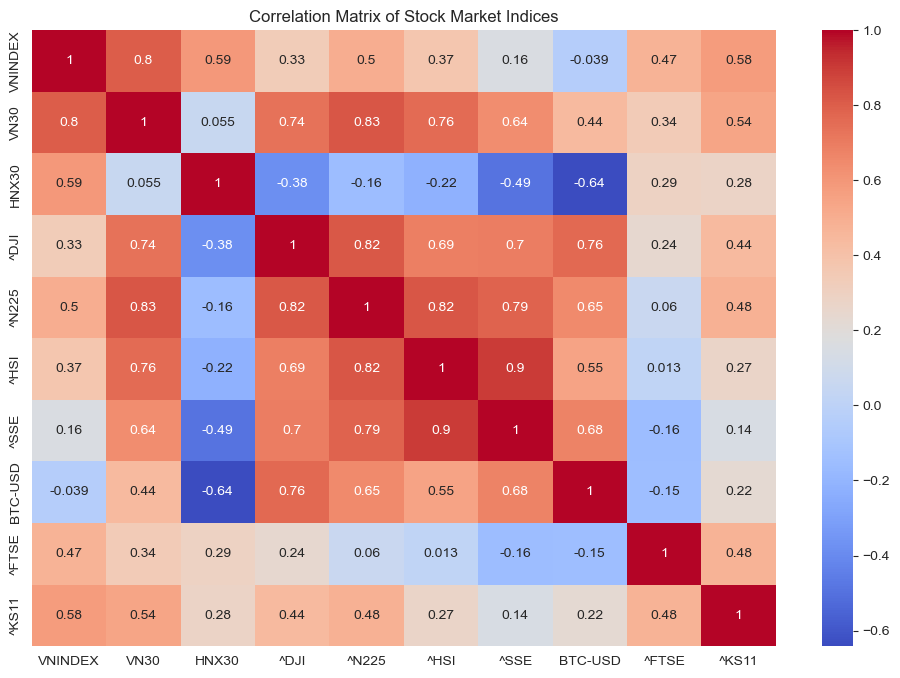

In [34]:
# Đọc dữ liệu từ csv trong folder price
dji_prices = pd.read_csv('price_index/DJI.csv')
n225_prices = pd.read_csv('price_index/N225.csv')
hsi_prices = pd.read_csv('price_index/HSI.csv')
vnindex_prices = pd.read_csv('price_index/VNI.csv')
vn30_prices = pd.read_csv('price_index/VN30.csv')
hnx30_prices = pd.read_csv('price_index/HNX30.csv')
sse_prices = pd.read_csv('price_index/SSE.csv')
btc_prices = pd.read_csv('price_index/BTC.csv')
ftse_prices = pd.read_csv('price_index/FTSE.csv')
ks11_prices = pd.read_csv('price_index/KS11.csv')

# Chuyển cột 'time' sang định dạng datetime
vnindex_prices['time'] = pd.to_datetime(vnindex_prices['time'], format='mixed')
vn30_prices['time'] = pd.to_datetime(vn30_prices['time'], format='mixed')
hnx30_prices['time'] = pd.to_datetime(hnx30_prices['time'], format='mixed')
dji_prices['time'] = pd.to_datetime(dji_prices['time'], format='mixed')
n225_prices['time'] = pd.to_datetime(n225_prices['time'], format='mixed')
hsi_prices['time'] = pd.to_datetime(hsi_prices['time'], format='mixed')
sse_prices['time'] = pd.to_datetime(sse_prices['time'], format='mixed')
btc_prices['time'] = pd.to_datetime(btc_prices['time'], format='mixed')
ftse_prices['time'] = pd.to_datetime(ftse_prices['time'], format='mixed')
ks11_prices['time'] = pd.to_datetime(ks11_prices['time'], format='mixed')

# Align the lengths of the price data with the date range
date_range = pd.date_range(start="2024-09-04", end="2024-11-08", freq='D')

# Reindex the price data to match the date range and fill missing values
vnindex_prices = vnindex_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
vn30_prices = vn30_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
hnx30_prices = hnx30_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
dji_prices = dji_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
n225_prices = n225_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
hsi_prices = hsi_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
sse_prices = sse_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
btc_prices = btc_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
ftse_prices = ftse_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()
ks11_prices = ks11_prices.set_index('time').reindex(date_range).ffill().bfill().reset_index()

data = {
    "time": date_range,
    "VNINDEX": vnindex_prices['close'],
    "VN30": vn30_prices['close'],
    "HNX30": hnx30_prices['close'],
    "^DJI": dji_prices['close'],
    "^N225": n225_prices['close'],
    "^HSI": hsi_prices['close'],
    "^SSE": sse_prices['close'],
    "BTC-USD": btc_prices['close'],
    "^FTSE": ftse_prices['close'],
    "^KS11": ks11_prices['close']
}

# Tạo DataFrame
mock_df = pd.DataFrame(data)

# Tính toán ma trận tương quan
correlation_matrix = mock_df.drop(columns=["time"]).corr()
correlation_matrix

# Tạo heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Stock Market Indices')
plt.show()

Nhận xét:
    - VN30 và VNINDEX


### Phân tích bình luận

#### 1. Tạo `wordcloud` từ `replies_df` để hiển thị các từ phổ biến trong phản hồi

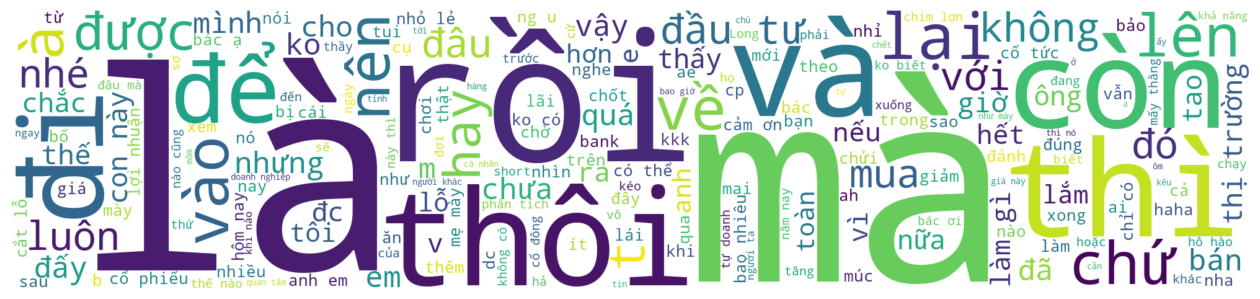

In [35]:

# Kết hợp tất cả văn bản từ cột 'originalContent'
text_filtered = " ".join(content for content in replies_df.originalContent)

# Tạo wordcloud
wordcloud_filtered = WordCloud(width=2000, height=450, background_color='white').generate(text_filtered)

plt.figure(figsize=(16, 6))
plt.imshow(wordcloud_filtered, interpolation='bilinear')
plt.axis('off')
plt.show()


In [36]:
# Tính số lần các từ xuất hiện
word_counts = Counter(words)

# Tạo dataframe từ kết quả
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

# Hiển thị
word_counts_df.head(20)

,word,count
355,có,86210
150,là,69733
217,và,60420
209,giá,55651
17,tăng,54028
197,thì,51827
203,này,49917
392,mua,49884
365,các,49813
294,bán,49239


In [37]:
# Tạo dataframe mới chứa ngày, số lượng phản hồi, sentiment và username
replies_summary = replies_df.loc[:, ['date', 'postID', 'originalContent', 'sentiment', 'username']]
replies_summary['reply_length'] = replies_summary['originalContent'].apply(lambda x: len(x))
replies_summary['sentiment'] = replies_summary['sentiment'].astype('string')
replies_summary['sentiment'] = replies_summary['sentiment'].replace({'1': 'positive', '0': 'neutral', '-1': 'negative'})
replies_summary['username'] = replies_summary['username'].astype('string')
replies_summary

,date,postID,originalContent,sentiment,username,reply_length
0,2024-11-06 16:37:32.923000+07:00,29100636,Bác có thể đưa ra kịch bản rằng : Họ sai!\nSố ...,neutral,NDC,80
1,2024-11-06 16:35:32.107000+07:00,29100614,"Sao số liệu tự doanh mỗi nơi mỗi khác nhỉ, nay...",neutral,Alex,90
2,2024-11-06 16:34:42.663000+07:00,29100602,hiện basic cạn cả cung cả cầu. Nn thoát basic ...,neutral,Upgrading to Fo,752
3,2024-11-06 16:34:04.070000+07:00,29100595,:)) bác lại chuẩn bài quá đó.,neutral,NDC,29
4,2024-11-06 16:33:33.900000+07:00,29100584,"rõ ràng phải có chữ NẾU, lỡ ko đc còn có cái m...",neutral,Tùng Cận,59
...,...,...,...,...,...,...
75505,2024-09-06 09:07:18.413000+07:00,28005671,☎Lh đầu tư SĐT/Zalo: 0934 318 921,neutral,Lượng VPA,33
75506,2024-09-06 09:07:13.367000+07:00,28005666,A.C tham gia cộng đồng Lượng VPA🕊 ở đây nhé👇,neutral,Lượng VPA,44
75507,2024-09-06 09:06:41.837000+07:00,28005646,3•\tKhuyến nghị\nBÁN CHỐT LỜI và QUẢN TRỊ RỦI ...,neutral,Lượng VPA,547
75508,2024-09-06 09:06:20.447000+07:00,28005631,2. •\tKhuyến nghị\nBÁN CHỐT LỜI FTS\nGiá bán :...,neutral,Lượng VPA,426


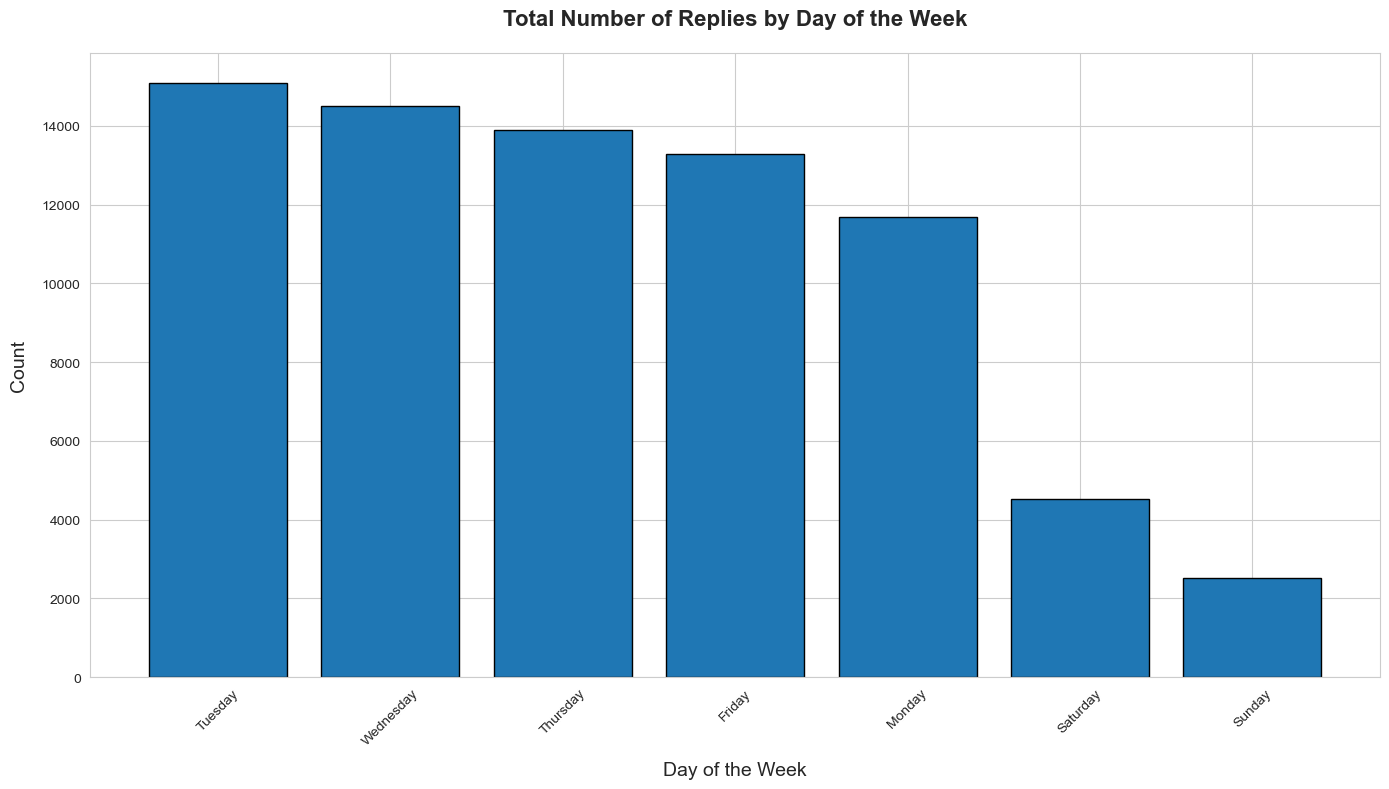

In [38]:
# Tạo column chart cho số lượng phản hồi theo thứ trong tuần
replies_summary['day_of_week'] = replies_summary['date'].dt.day_name()
replies_summary['day_of_week'] = pd.Categorical(replies_summary['day_of_week'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
replies_by_day = replies_summary['day_of_week'].value_counts().reset_index()
replies_by_day.columns = ['day_of_week', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
plt.bar(replies_by_day['day_of_week'], replies_by_day['count'], color='#1f77b4', edgecolor='black')

# Thêm nhãn và chú thích
plt.title('Total Number of Replies by Day of the Week', fontsize=16, weight='bold', pad=20)
plt.xlabel('Day of the Week', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


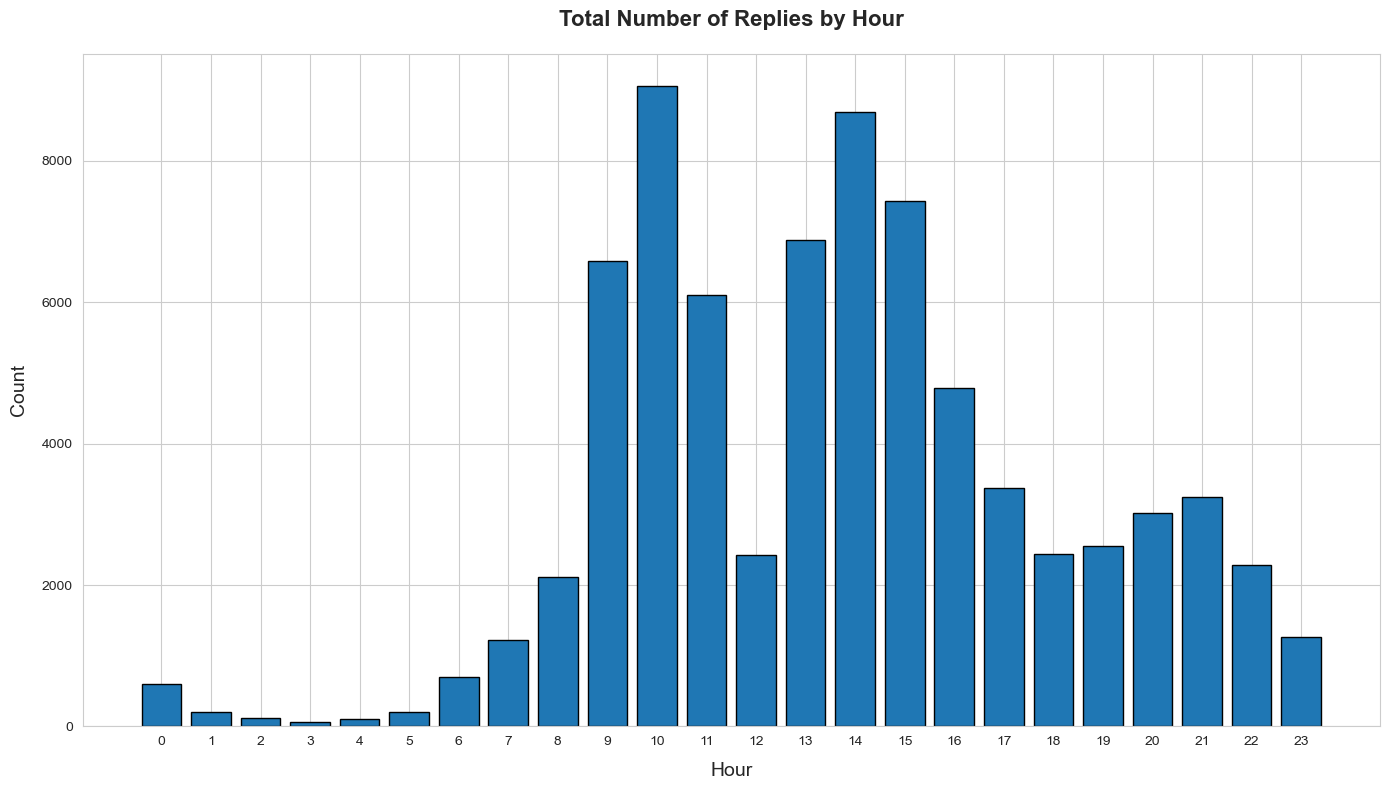

In [39]:
# Chuyển đổi cột 'date' sang định dạng datetime nếu chưa được chuyển đổi
replies_summary['date'] = pd.to_datetime(replies_summary['date'], format='ISO8601')

# Tạo column chart cho số lượng phản hồi theo giờ.
reply_counts_by_hour = replies_summary.groupby(replies_summary['date'].dt.hour).size().reset_index()
reply_counts_by_hour.columns = ['hour', 'reply_count']

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
plt.bar(reply_counts_by_hour['hour'], reply_counts_by_hour['reply_count'], color='#1f77b4', edgecolor='black')

# Thêm nhãn và chú thích
plt.title('Total Number of Replies by Hour', fontsize=16, weight='bold', pad=20)
plt.xlabel('Hour', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(reply_counts_by_hour['hour'], fontsize=10)
plt.yticks(fontsize=10)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [40]:
# Tìm user có lượt bình luận từ nhiều nhất đến ít nhất
top_repliers = replies_df['username'].value_counts().reset_index()
top_repliers.columns = ['username', 'numofreplies']
top_repliers.head(20)

,username,numofreplies
0,NDC,1808
1,ㅤㅤ ㅤChênh Q9,660
2,Minh Nguyễn Invest,532
3,Việt Stock,459
4,Hữu Nam,423
5,Lượng VPA,410
6,Game SBT,379
7,Triệt Quyền Đạo(Triệt Chim Gà Lợn),362
8,Doan Nhan,357
9,Nam Dao,344


Liệu rằng username có ảnh hưởng đến số lượng tương tác của bài viết không.

In [41]:
# trích xuất thông tin từ 100 bài viết có lượt bình luận cao nhất
top_100_replies = posts_summary.sort_values(by='total_replies', ascending=False).head(100)
top_100_replies

,date,postID,originalContent,sentiment,taggedSymbols,post_length,total_likes,total_replies
245929,2024-09-26 13:20:06.443000+07:00,28340183,Thức dậy đi chú Đạt,neutral,"[{""symb"": ""PDR"", ""price"": 22.9}]",19,0,693
4,2024-10-03 15:27:47.050000+07:00,28483887,Phái Sinh ngày 3/10/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""$BTC"", ""price"": 61459.01}, {""symb"":...",774,62,151
138448,2024-09-13 14:50:29.640000+07:00,28124694,Lên đc tí xanh để đỡ phải bị dân tình chửi àh!...,neutral,"[{""symb"": ""DIG"", ""price"": 22.0}, {""symb"": ""VNI...",181,1,137
13,2024-11-06 15:27:39.133000+07:00,29099549,Phái Sinh ngày 6/11/2024\n.\n- Hnay Tây Long r...,neutral,"[{""symb"": ""^DJI"", ""price"": 42221.88}, {""symb"":...",841,55,130
0,2024-10-24 15:19:54.307000+07:00,28869167,Phái Sinh ngày 24/10/2024\n.\n- Hnay Tây Short...,neutral,"[{""symb"": ""^DJI"", ""price"": 42514.95}, {""symb"":...",836,69,125
...,...,...,...,...,...,...,...,...
197283,2024-10-15 18:43:58.110000+07:00,28690984,12 giữ dc ko a e,neutral,"[{""symb"": ""VIX"", ""price"": 11.3}]",17,0,50
9009,2024-09-28 12:53:17.447000+07:00,28382940,Huynh cho đệ hỏi đánh chứng khoán có dễ lãi th...,neutral,"[{""symb"": ""CTG"", ""price"": 37.0}, {""symb"": ""HCM...",85,4,50
24073,2024-10-26 11:00:47.683000+07:00,28901061,"ISRAEL - IRAN LẠI TỔ CHỨC TẬP TRẬN CHUNG, LẦN ...",neutral,"[{""symb"": ""EIB"", ""price"": 20.85}, {""symb"": ""HH...",357,3,49
24,2024-09-23 15:24:40.777000+07:00,28273511,Phái Sinh ngày 23/9/2024\n.\n- Hnay Tây Short ...,neutral,"[{""symb"": ""^DJI"", ""price"": 42124.65}, {""symb"":...",682,50,49


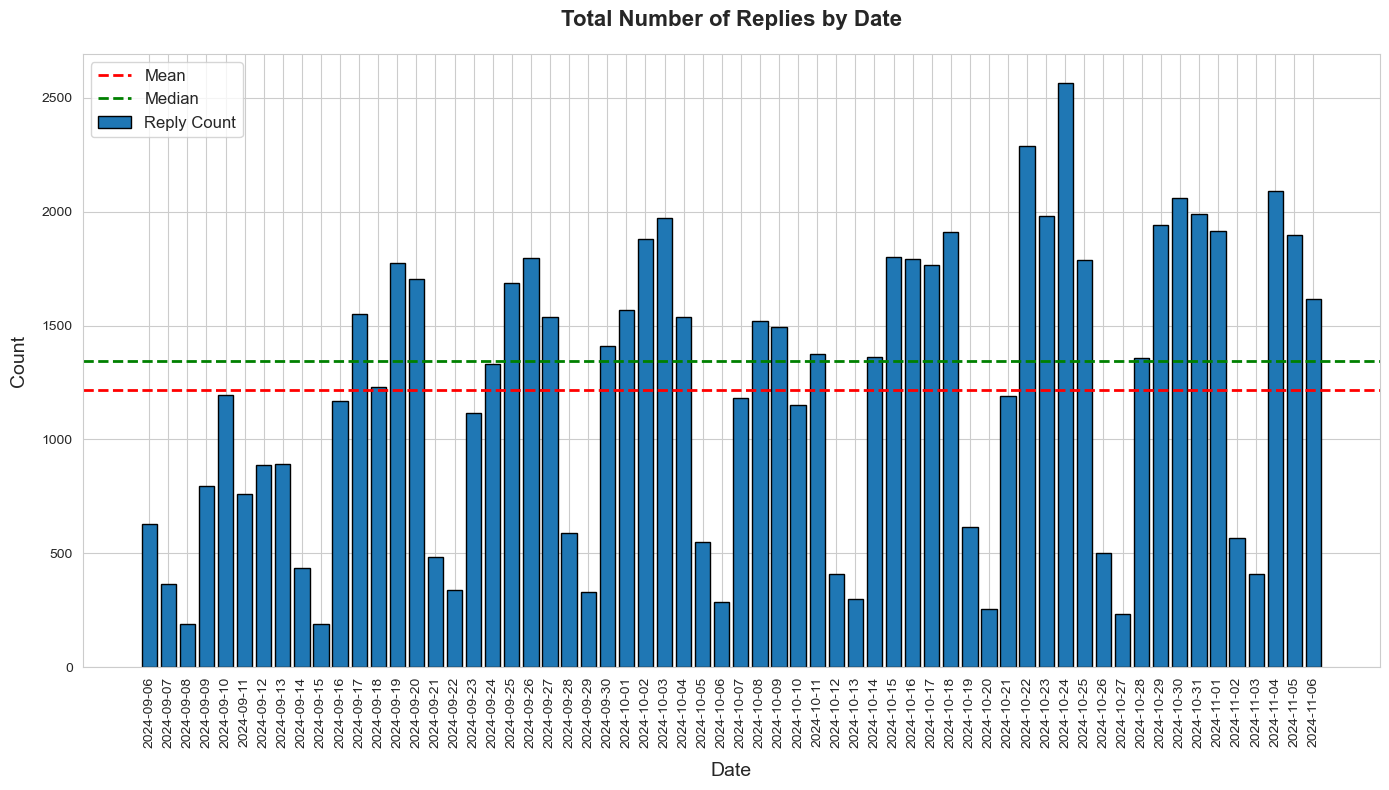

In [57]:
# Chuyển đổi cột 'date' sang định dạng datetime
replies_df['date'] = pd.to_datetime(replies_df['date'], format='ISO8601')

# Tạo dataframe mới chứa ngày, số lượng phản hồi
reply_counts_by_date = replies_df.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
reply_counts_by_date.columns = ['date', 'reply_count']
reply_counts_by_date['date'] = reply_counts_by_date['date'].dt.strftime('%Y-%m-%d')
reply_mean_value = reply_counts_by_date['reply_count'].mean()
reply_median_value = reply_counts_by_date['reply_count'].median()

# Tạo biểu đồ cột
plt.figure(figsize=(14, 8))
plt.bar(reply_counts_by_date['date'], reply_counts_by_date['reply_count'], color='#1f77b4', edgecolor='black', label = 'Reply Count')

plt.axhline(y=reply_mean_value, color='red', linestyle='--', linewidth=2, label='Mean')

plt.axhline(y=reply_median_value, color='green', linestyle='--', linewidth=2, label='Median')

# Thêm nhãn và chú thích
plt.title('Total Number of Replies by Date', fontsize=16, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left')

# Tăng khoảng cách và hiển thị biểu đồ
plt.tight_layout()
plt.show()

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\722668413.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\722668413.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




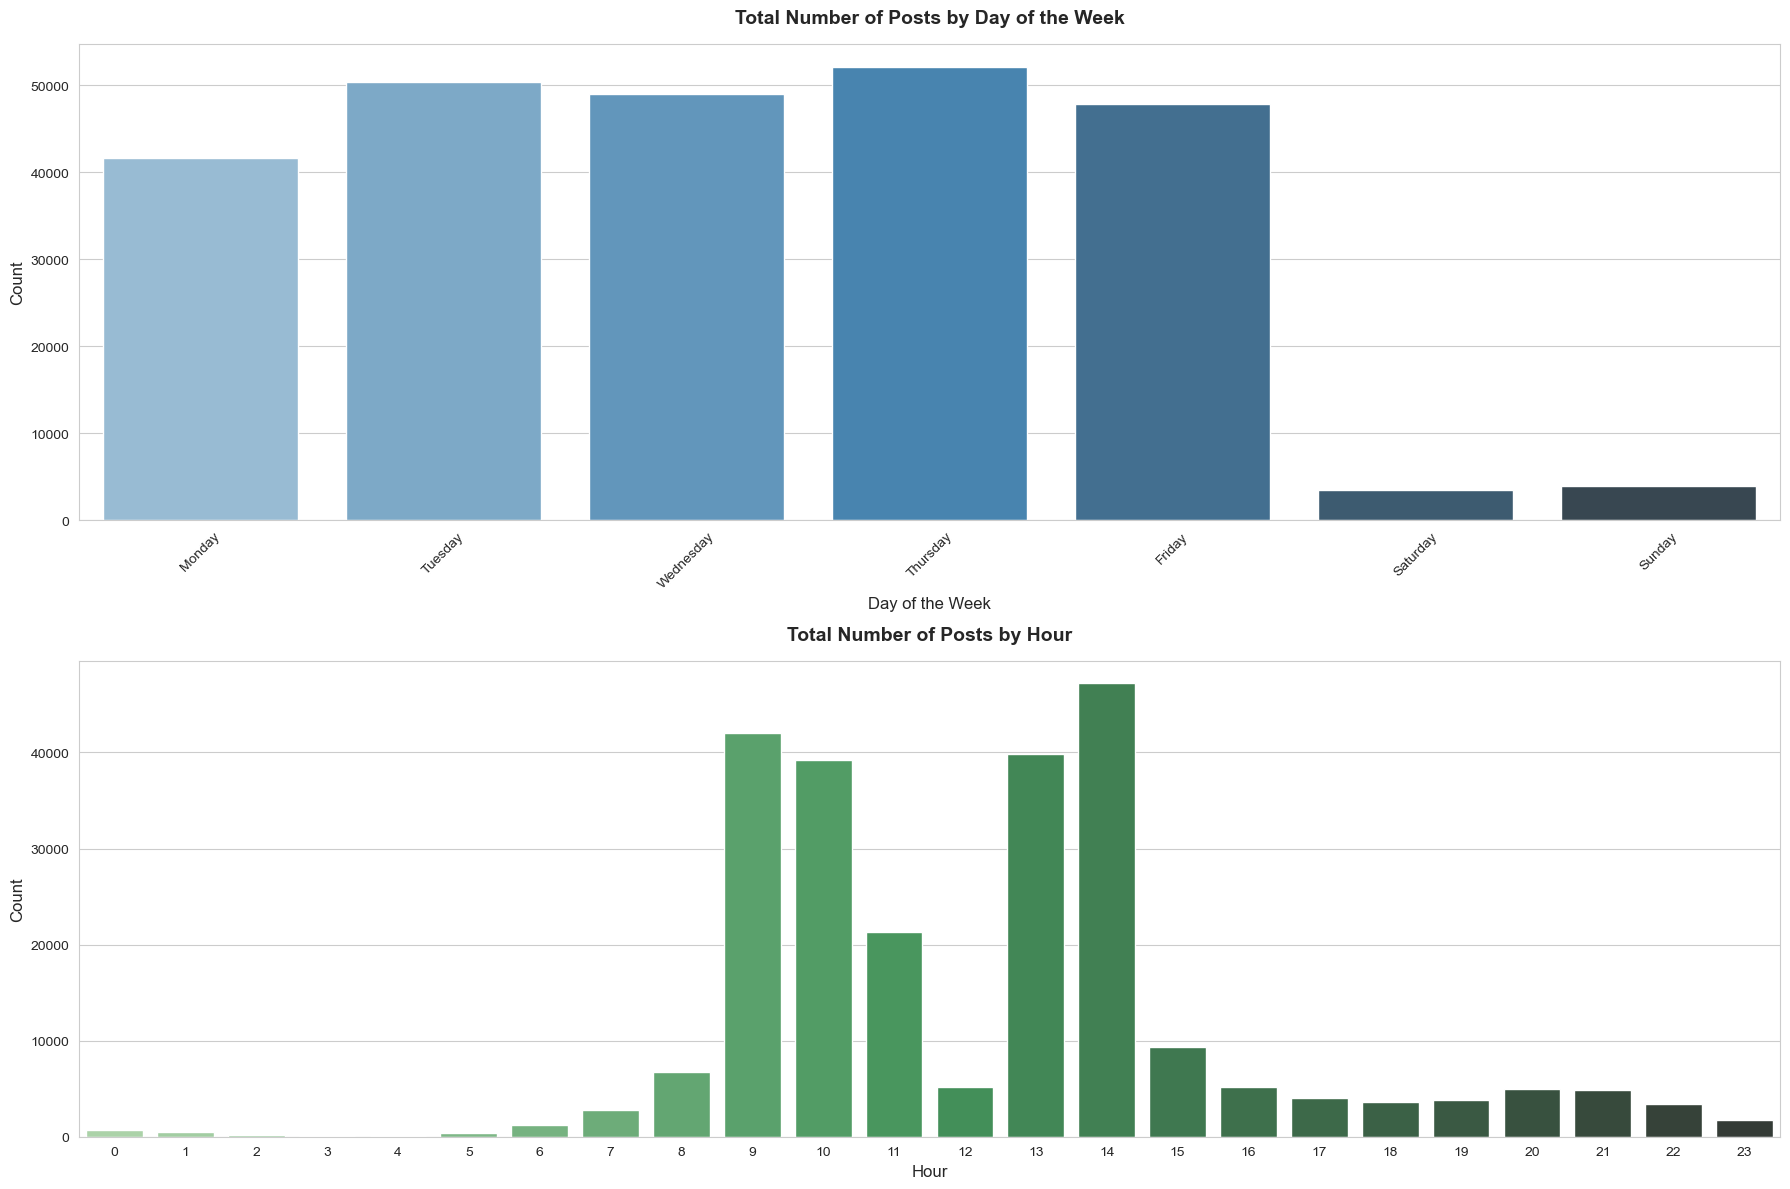

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

start_date = '2024-09-08'
end_date = '2024-11-02'

posts_df = posts_df[(posts_df['date'] >= start_date) & (posts_df['date'] <= end_date)]
replies_summary = replies_summary[(replies_summary['date'] >= start_date) & (replies_summary['date'] <= end_date)]
posts_df['day_of_week'] = posts_df['date'].dt.day_name()
posts_df['day_of_week'] = pd.Categorical(posts_df['day_of_week'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Số lượng bài viết theo ngày trong tuần
posts_by_day = posts_df['day_of_week'].value_counts().reset_index()
posts_by_day.columns = ['day_of_week', 'count']

# Số lượng bài viết theo giờ
post_counts_by_hour = posts_df.groupby(posts_df['date'].dt.hour).size().reset_index()
post_counts_by_hour.columns = ['hour', 'post_count']

# Thiết lập bảng màu và phong cách
sns.set_palette("pastel")
sns.set_style("whitegrid")

fig, axs = plt.subplots(2, figsize=(18, 12))


sns.barplot(data=posts_by_day, x='day_of_week', y='count', ax=axs[0], palette="Blues_d")
axs[0].set_title('Total Number of Posts by Day of the Week', fontsize=14, weight='bold', pad=15)
axs[0].set_xlabel('Day of the Week', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)



sns.barplot(data=post_counts_by_hour, x='hour', y='post_count', ax=axs[1], palette="Greens_d")
axs[1].set_title('Total Number of Posts by Hour', fontsize=14, weight='bold', pad=15)
axs[1].set_xlabel('Hour', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)

# Tinh chỉnh khoảng cách và hiển thị
plt.tight_layout()
plt.show()


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\812887671.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\812887671.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




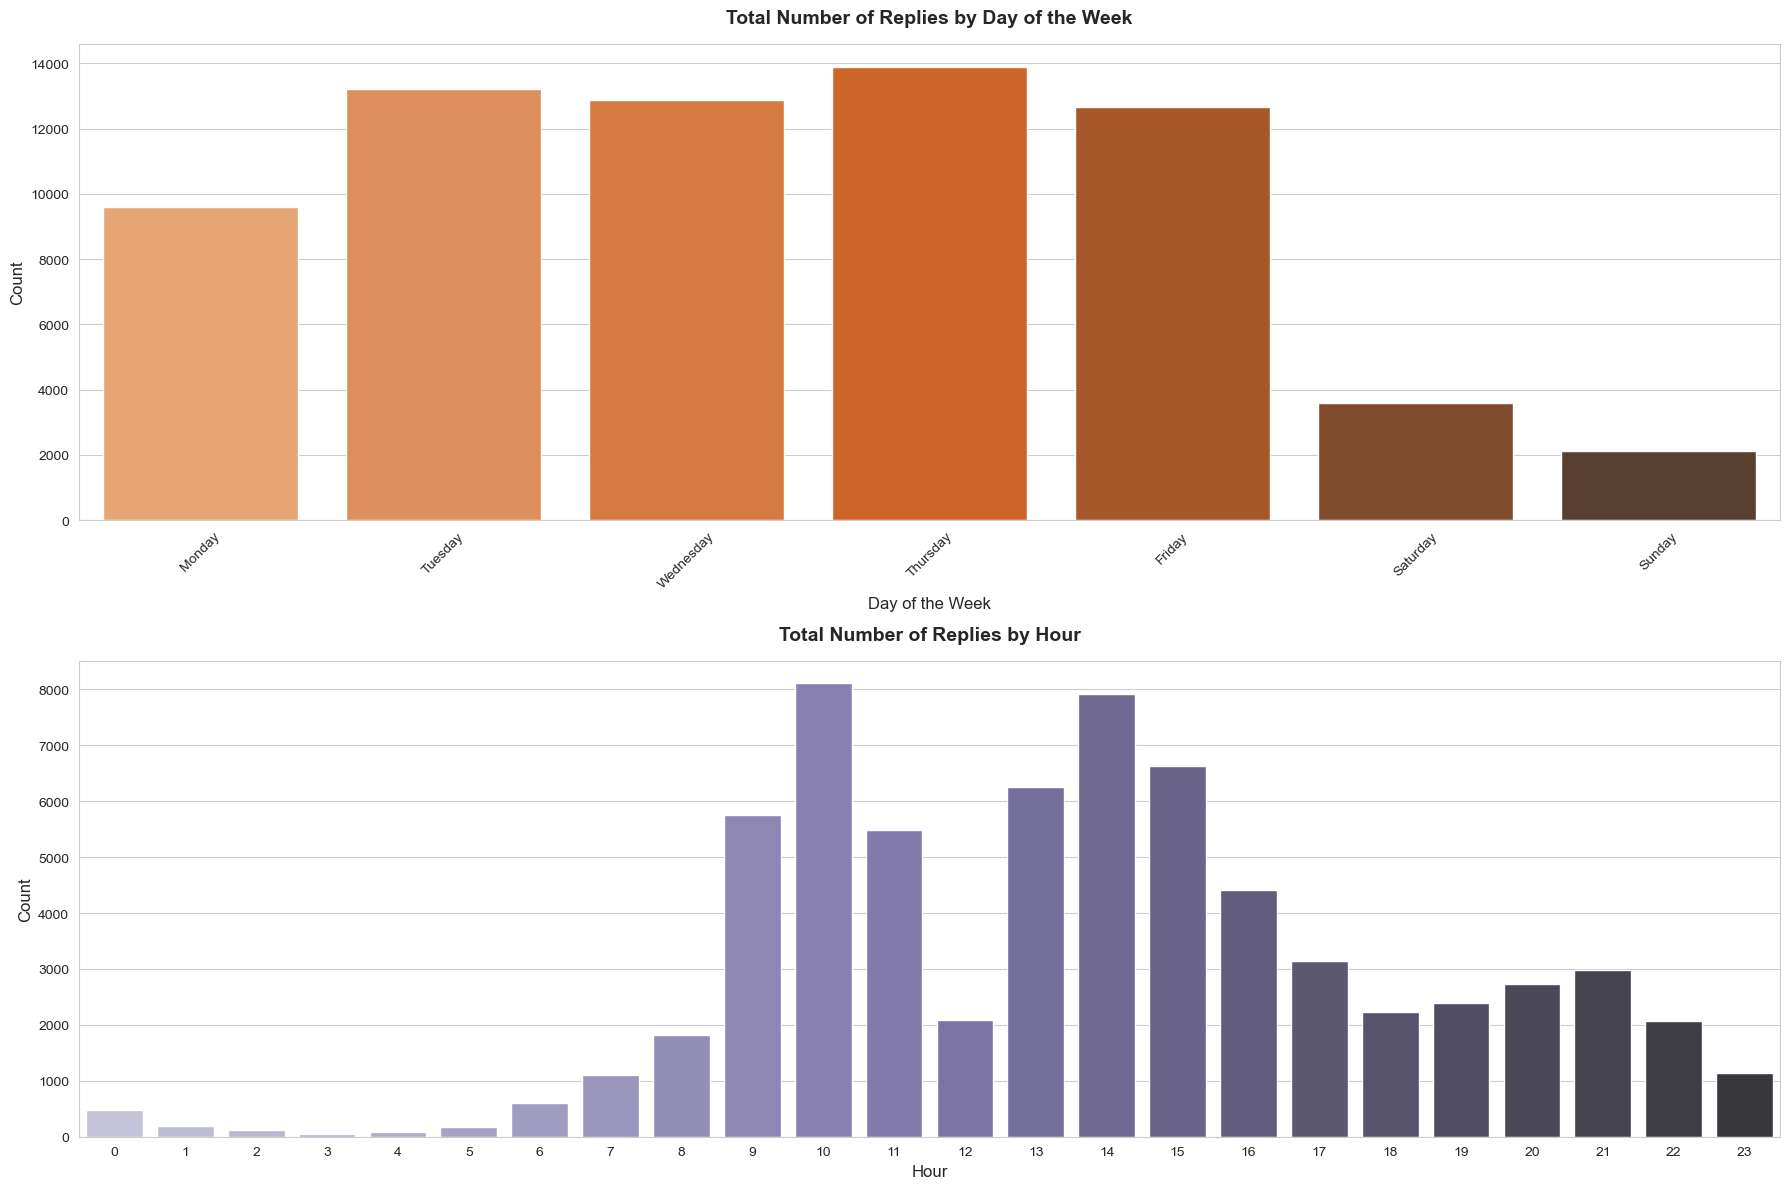

In [ ]:
start_date = '2024-09-08'
end_date = '2024-11-02'

posts_df = posts_df[(posts_df['date'] >= start_date) & (posts_df['date'] <= end_date)]
replies_summary = replies_summary[(replies_summary['date'] >= start_date) & (replies_summary['date'] <= end_date)]

# 3. Số lượng phản hồi theo thứ trong tuần
replies_summary['day_of_week'] = replies_summary['date'].dt.day_name()
replies_summary['day_of_week'] = pd.Categorical(replies_summary['day_of_week'], categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
replies_by_day = replies_summary['day_of_week'].value_counts().reset_index()
replies_by_day.columns = ['day_of_week', 'count']

# 4. Số lượng phản hồi theo giờ
reply_counts_by_hour = replies_summary.groupby(replies_summary['date'].dt.hour).size().reset_index()
reply_counts_by_hour.columns = ['hour', 'reply_count']

# Thiết lập bảng màu và phong cách
sns.set_palette("pastel")
sns.set_style("whitegrid")

fig, axs = plt.subplots(2, figsize=(18, 12))


sns.barplot(data=replies_by_day, x='day_of_week', y='count', ax=axs[0], palette="Oranges_d")
axs[0].set_title('Total Number of Replies by Day of the Week', fontsize=14, weight='bold', pad=15)
axs[0].set_xlabel('Day of the Week', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

sns.barplot(data=reply_counts_by_hour, x='hour', y='reply_count', ax=axs[1], palette="Purples_d")
axs[1].set_title('Total Number of Replies by Hour', fontsize=14, weight='bold', pad=15)
axs[1].set_xlabel('Hour', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)

# Tinh chỉnh khoảng cách và hiển thị
plt.tight_layout()
plt.show()

### Phân tích nhận định

In [45]:
# Trích xuất mã từ cột 'taggedSymbols'
posts_df['symbols'] = posts_df['taggedSymbols'].apply(lambda x: [d['symb'] for d in eval(x)])

# Tạo một dataframe mới chứa các mã và sentiment
symbols_df = posts_df.explode('symbols')[['symbols', 'sentiment']]

# Đếm số lượng xuất hiện của mỗi mã
symbol_counts = symbols_df['symbols'].value_counts().reset_index()
symbol_counts.columns = ['symbol', 'count']

# Kết hợp với sentiment
result_df = symbols_df.groupby('symbols')['sentiment'].first().reset_index()
result_df = result_df.merge(symbol_counts, left_on='symbols', right_on='symbol').drop(columns=['symbols'])

# Sắp xếp theo lượt xuất hiện của mã giảm dần
result_df = result_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Xóa cột 'sentiment'
result_df = result_df.drop(columns=['sentiment'])

# Thêm các cột mới
result_df['positive'] = symbols_df[symbols_df['sentiment'] == 'positive'].groupby('symbols').size().reindex(result_df['symbol'], fill_value=0).values
result_df['neutral'] = symbols_df[symbols_df['sentiment'] == 'neutral'].groupby('symbols').size().reindex(result_df['symbol'], fill_value=0).values
result_df['negative'] = symbols_df[symbols_df['sentiment'] == 'negative'].groupby('symbols').size().reindex(result_df['symbol'], fill_value=0).values

result_df


,symbol,count,positive,neutral,negative
0,VNINDEX,49891,8192,38502,3197
1,HPG,12081,2956,8592,533
2,VHM,11109,1773,8756,580
3,VN30F1M,10356,2063,7698,595
4,DXG,9452,2130,6909,413
...,...,...,...,...,...
1425,RCD,1,1,0,0
1426,RBEX24,1,0,1,0
1427,QWZ24,1,0,1,0
1428,QWK25,1,0,1,0


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\2157267927.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



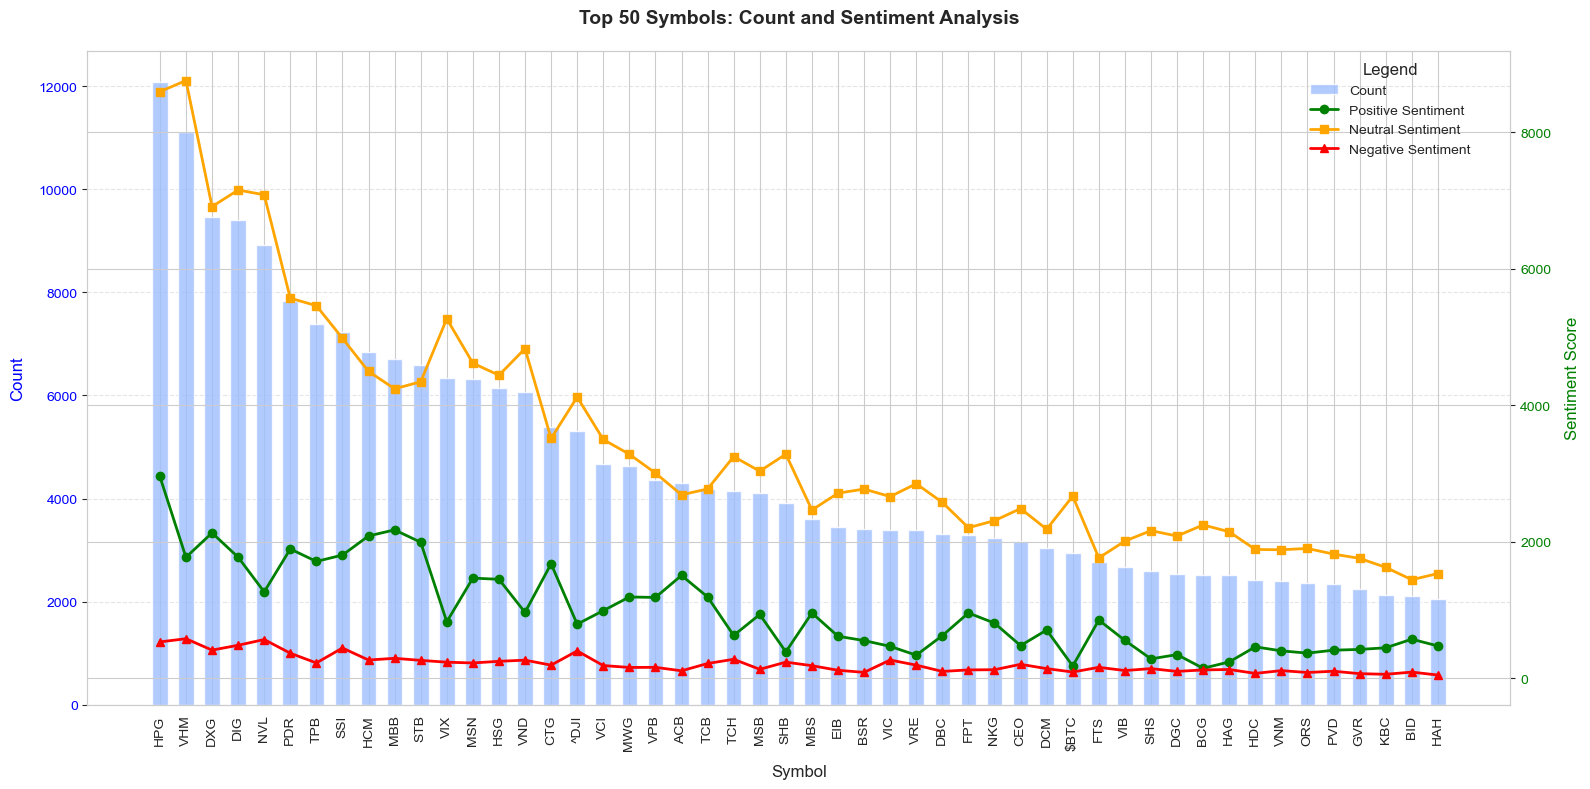

In [46]:
# Lọc bỏ các mã không cần thiết
filtered_result_df = result_df[~result_df['symbol'].isin(['VN30', 'VN30F1M', 'VNINDEX'])]

# Lấy top 50 symbols
top_50 = filtered_result_df[:50]

# Tạo biểu đồ
fig, ax1 = plt.subplots(figsize=(16, 8))

# Biểu đồ cột cho số lượng xuất hiện
bar_width = 0.6
colors = sns.color_palette("coolwarm", as_cmap=True)  # Dùng palette đẹp từ seaborn
ax1.bar(
    top_50['symbol'], 
    top_50['count'], 
    color=colors(0.3), 
    alpha=0.8, 
    width=bar_width, 
    label='Count'
)
ax1.set_xlabel('Symbol', fontsize=12, labelpad=10)
ax1.set_ylabel('Count', fontsize=12, color='b', labelpad=10)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(top_50['symbol'], rotation=90, fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Tạo trục y thứ hai cho sentiment
ax2 = ax1.twinx()
ax2.plot(
    top_50['symbol'], 
    top_50['positive'], 
    color='g', 
    marker='o', 
    linestyle='-', 
    linewidth=2, 
    label='Positive Sentiment'
)
ax2.plot(
    top_50['symbol'], 
    top_50['neutral'], 
    color='orange', 
    marker='s', 
    linestyle='-', 
    linewidth=2, 
    label='Neutral Sentiment'
)
ax2.plot(
    top_50['symbol'], 
    top_50['negative'], 
    color='r', 
    marker='^', 
    linestyle='-', 
    linewidth=2, 
    label='Negative Sentiment'
)
ax2.set_ylabel('Sentiment Score', fontsize=12, color='g', labelpad=10)
ax2.tick_params(axis='y', labelcolor='g')

# Thêm chú thích và tiêu đề
fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.93, 0.93), 
    fontsize=10, 
    frameon=False, 
    title="Legend", 
    title_fontsize=12
)
plt.title('Top 50 Symbols: Count and Sentiment Analysis', fontsize=14, pad=20, weight='bold')

# Tăng khoảng cách giữa các thành phần để không bị chồng chéo
fig.tight_layout()

# Hiển thị biểu đồ
plt.show()

?? xét tỉ lệ pos và neg

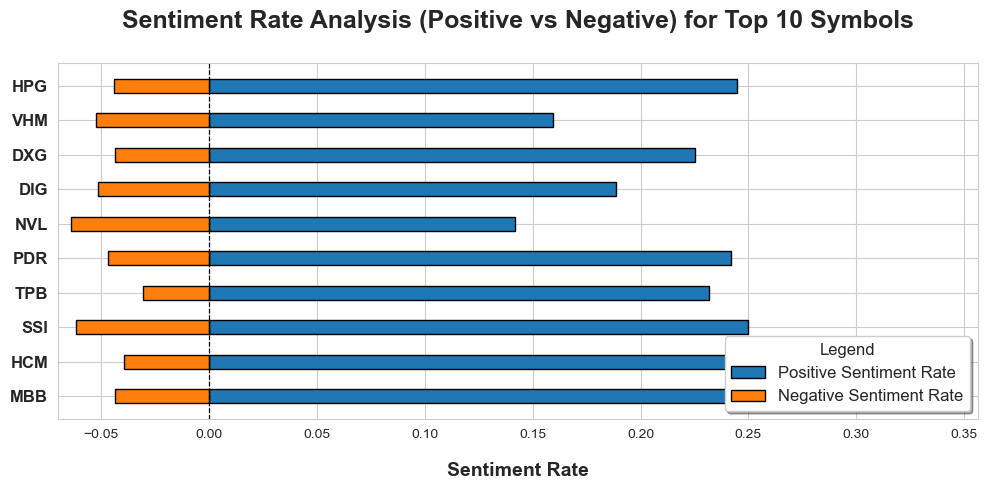

In [47]:
# Import thư viện cần thiết
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tạo dataframe chứa tỷ lệ sentiment
sentiment_df = result_df.copy()
sentiment_df['positive_rate'] = sentiment_df['positive'] / sentiment_df['count']
sentiment_df['negative_rate'] = sentiment_df['negative'] / sentiment_df['count']

# Sắp xếp theo số lần xuất hiện, lọc bỏ các mã không cần thiết và lấy top 10
sentiment_df = sentiment_df[~sentiment_df['symbol'].isin(['VN30', 'VN30F1M', 'VNINDEX'])]
sentiment_df = sentiment_df.sort_values(by='count', ascending=False).reset_index()
top_10 = sentiment_df[:10].iloc[::-1]

# Thiết lập màu sắc và style
sns.set_palette("muted")
sns.set_style("whitegrid")

# Tạo bar chart
fig, ax = plt.subplots(figsize=(10,5))

# Xây dựng biểu đồ dạng bar hai phía
x = np.arange(len(top_10))  # Index cho symbols
bar_width = 0.4

# Positive sentiment bars
ax.barh(x, top_10['positive_rate'], color='#1f77b4', edgecolor='black', height=bar_width, label='Positive Sentiment Rate')

# Negative sentiment bars
ax.barh(x, -top_10['negative_rate'], color='#ff7f0e', edgecolor='black', height=bar_width, label='Negative Sentiment Rate')

# Thiết kế các nhãn
ax.set_yticks(x)
ax.set_yticklabels(top_10['symbol'], fontsize=12, weight='bold')
ax.set_xlabel('Sentiment Rate', fontsize=14, labelpad=15, weight='bold')
ax.set_title('Sentiment Rate Analysis (Positive vs Negative) for Top 10 Symbols', fontsize=18, weight='bold', pad=25)

# Thêm đường trục giữa để dễ phân biệt
ax.axvline(0, color='black', linewidth=0.9, linestyle='--')
ax.set_xlim(-max(top_10['negative_rate']) * 1.1, max(top_10['positive_rate']) * 1.1)

# Thêm chú thích
ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True, title="Legend", title_fontsize=12)
# Điều chỉnh layout để không bị chồng chéo
fig.tight_layout()

# Hiển thị biểu đồ
plt.show()


Từ 2 plot trên ta thấy rằng:
- HPG, VHM, DXG là các mã được chú ý nhiều nhất, với cảm xúc chủ yếu là trung lập và tích cực.
- Phân tích này có thể gợi ý rằng các mã đứng đầu đang là tâm điểm theo dõi của thị trường.
- Tuy nhiên, mức cảm xúc tiêu cực khá thấp cho thấy tâm lý chung của nhà đầu tư vẫn tương đối ổn định.

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\2962568998.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




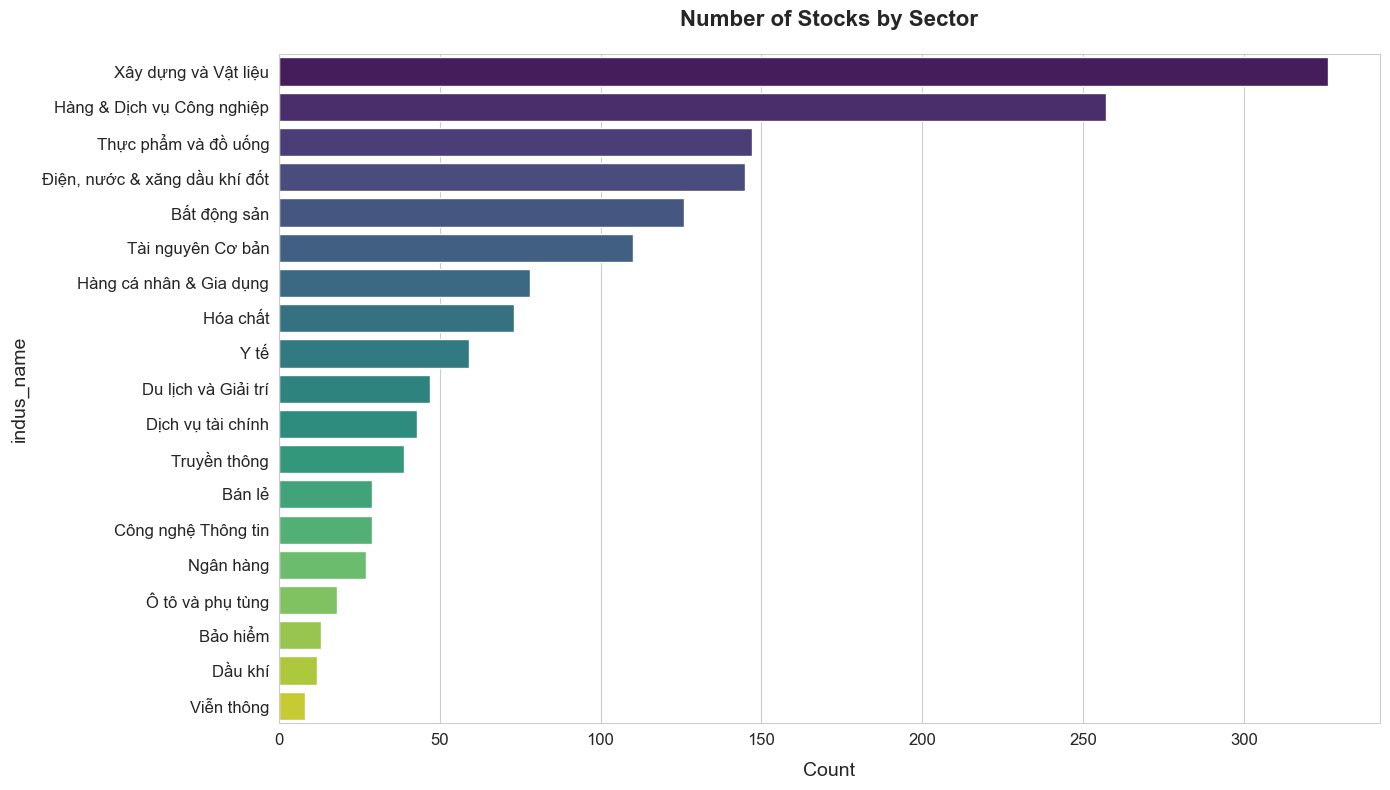

In [48]:
# Liệt ngành trong list_stock.csv và số lượng mã chứng khoán của mỗi ngành
sectors = pd.read_csv('list_stock.csv')
sectors['indus_name'] = sectors['indus_name'].str.strip()
sector_counts = sectors['indus_name'].value_counts().reset_index()
sector_counts.columns = ['indus_name', 'count']
sector_counts

# Tạo biểu đồ
plt.figure(figsize=(14, 8))
sns.barplot(data=sector_counts, x='count', y='indus_name', palette='viridis')
plt.title('Number of Stocks by Sector', fontsize=16, weight='bold', pad=20)
plt.xlabel('Count', fontsize=14, labelpad=10)
plt.ylabel('indus_name', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



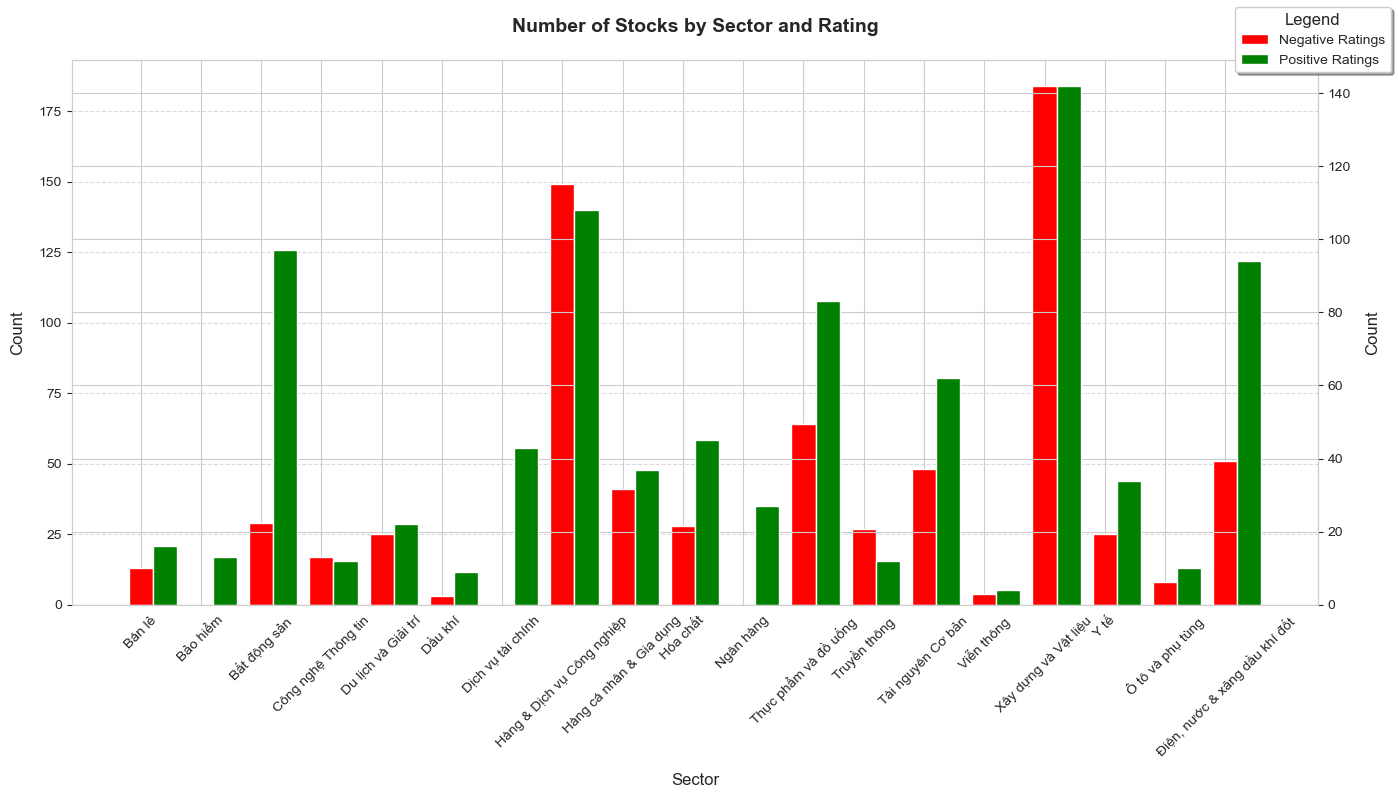

In [49]:
# Group by 'indus_name' và tính tổng số mã có r_tcbsrating < 0 cho mỗi ngành và số mã có r_tcbsrating > 0
sector_ratings = sectors.groupby('indus_name')['r_tcbsrating'].agg(lambda x: (x < 0).sum()).reset_index()
sector_ratings.columns = ['indus_name', 'negative_count']
sector_ratings['positive_count'] = sectors.groupby('indus_name')['r_tcbsrating'].agg(lambda x: (x > 0).sum()).values
sector_ratings

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(14, 8))

# Vẽ biểu đồ cột cho số lượng mã có r_tcbsrating < 0
bar_width = 0.4
x = np.arange(len(sector_ratings))
ax.bar(x, sector_ratings['negative_count'], color='r', width=bar_width, label='Negative Ratings')
ax.set_xlabel('Sector', fontsize=12, labelpad=10)
ax.set_ylabel('Count', fontsize=12, labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(sector_ratings['indus_name'], fontsize=10)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tạo trục y thứ hai cho số lượng mã có r_tcbsrating > 0
ax2 = ax.twinx()
ax2.bar(x + bar_width, sector_ratings['positive_count'], color='g', width=bar_width, label='Positive Ratings')
ax2.set_ylabel('Count', fontsize=12, labelpad=10)
ax2.tick_params(axis='y')

# Thêm chú thích và tiêu đề
fig.legend(loc='upper right', fontsize=10, title='Legend', title_fontsize=12, frameon=True, shadow=True)
plt.title('Number of Stocks by Sector and Rating', fontsize=14, weight='bold', pad=20)

# Tăng kho
fig.tight_layout()

# Hiển thị biểu đồ
plt.show()

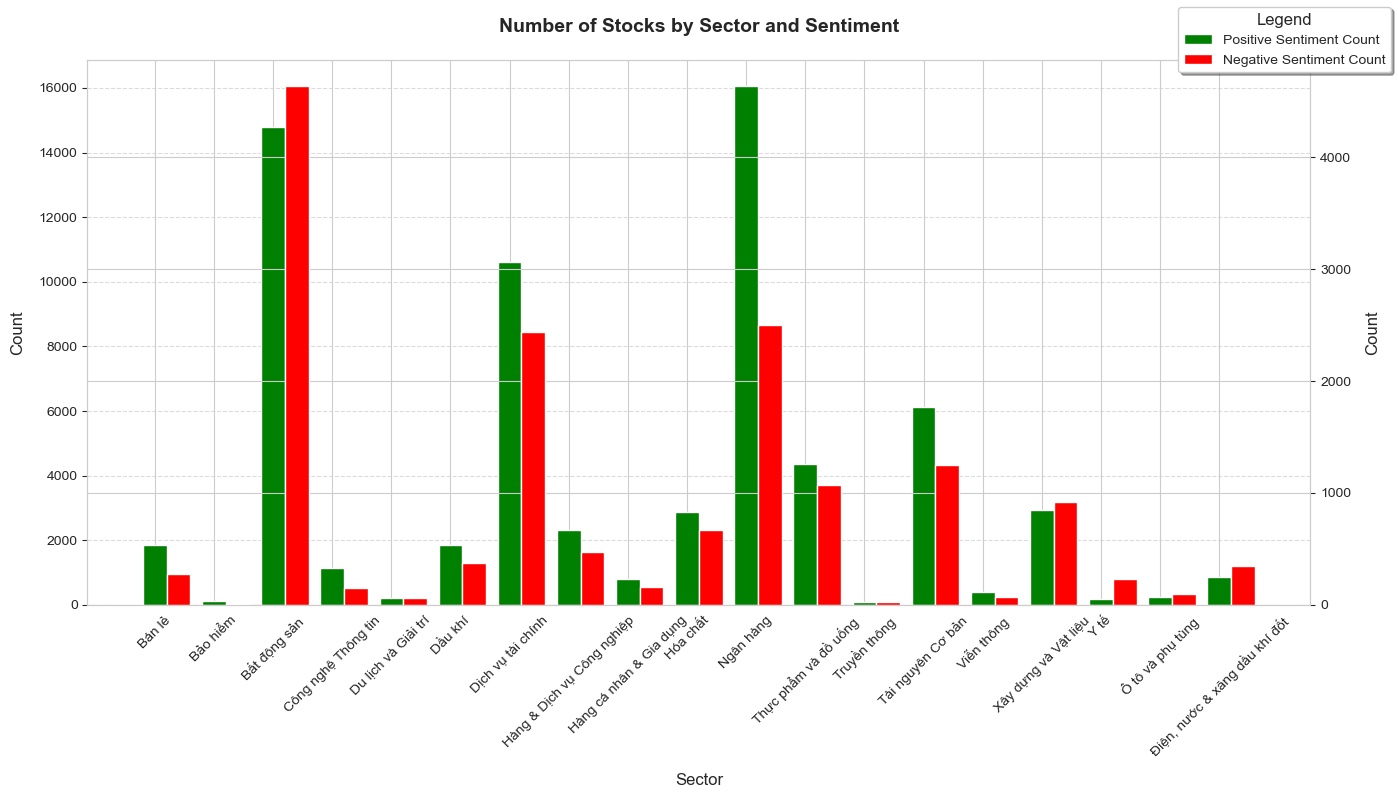

In [50]:
# Merge dữ liệu từ list_stock.csv để lấy indus_name vào result_df 
result_df = result_df.merge(sectors[['symbol', 'indus_name']], left_on='symbol', right_on='symbol', suffixes=('', '_y'))

# Group by 'indus_name' và tính tổng số mã có sentiment positive cho mỗi ngành và số mã có sentiment negative
sector_sentiments = result_df.groupby('indus_name')['positive'].sum().reset_index()
sector_sentiments.columns = ['indus_name', 'positive_count']
sector_sentiments['negative_count'] = result_df.groupby('indus_name')['negative'].sum().values
sector_sentiments

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(14, 8))

# Vẽ biểu đồ cột cho số lượng mã có sentiment positive
bar_width = 0.4
x = np.arange(len(sector_sentiments))

# Positive sentiment bars
ax.bar(x, sector_sentiments['positive_count'], color='g', width=bar_width, label='Positive Sentiment Count')
ax.set_xlabel('Sector', fontsize=12, labelpad=10)
ax.set_ylabel('Count', fontsize=12, labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(sector_sentiments['indus_name'], fontsize=10)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Negative sentiment bars
ax2 = ax.twinx()
ax2.bar(x + bar_width, sector_sentiments['negative_count'], color='r', width=bar_width, label='Negative Sentiment Count')
ax2.set_ylabel('Count', fontsize=12, labelpad=10)
ax2.tick_params(axis='y')

# Thêm chú thích và tiêu đề
fig.legend(loc='upper right', fontsize=10, title='Legend', title_fontsize=12, frameon=True, shadow=True)
plt.title('Number of Stocks by Sector and Sentiment', fontsize=14, weight='bold', pad=20)

# Tăng kho
fig.tight_layout()

# Hiển thị biểu đồ
plt.show()

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\102736605.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\102736605.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




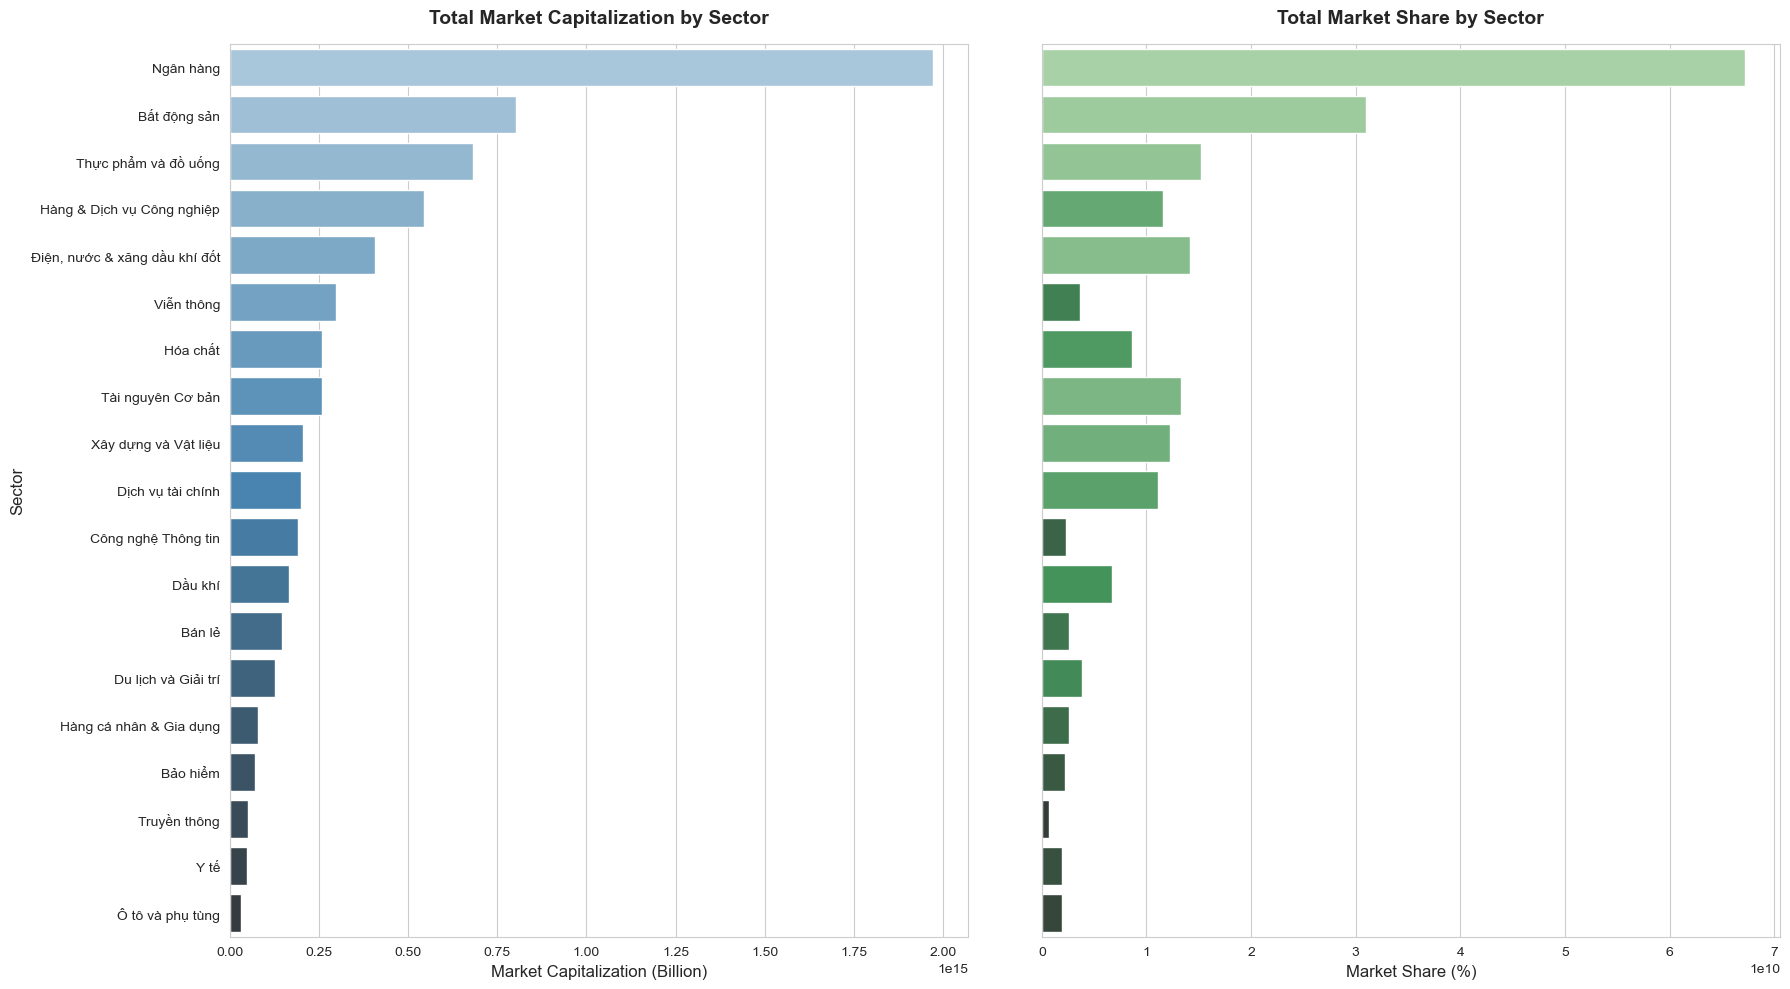

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu
mcap_df = pd.read_csv('list_stock.csv')
mcap_df = mcap_df[['symbol', 'm_cap', 'm_share', 'indus_name']]
mcap_df['indus_name'] = mcap_df['indus_name'].str.strip()

# Merge dữ liệu từ mcap_df vào result_df (giả sử result_df đã có)
result_df = result_df.merge(mcap_df, left_on='symbol', right_on='symbol', suffixes=('', '_y'))

# Tính tổng Market Cap và Market Share theo ngành
sector_mcap = result_df.groupby('indus_name')['m_cap'].sum().reset_index()
sector_mcap.columns = ['indus_name', 'total_mcap']
sector_mcap = sector_mcap.sort_values(by='total_mcap', ascending=False)

sector_mshare = result_df.groupby('indus_name')['m_share'].sum().reset_index()
sector_mshare.columns = ['indus_name', 'total_mshare']
sector_mshare = sector_mshare.sort_values(by='total_mshare', ascending=False)

# Thiết kế lại đồ thị
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

# Biểu đồ Market Capitalization
sns.barplot(
    data=sector_mcap,
    x='total_mcap',
    y='indus_name',
    ax=axes[0],
    palette='Blues_d'
)
axes[0].set_title('Total Market Capitalization by Sector', fontsize=14, weight='bold', pad=15)
axes[0].set_xlabel('Market Capitalization (Billion)', fontsize=12)
axes[0].set_ylabel('Sector', fontsize=12)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)

# Biểu đồ Market Share
sns.barplot(
    data=sector_mshare,
    x='total_mshare',
    y='indus_name',
    ax=axes[1],
    palette='Greens_d'
)
axes[1].set_title('Total Market Share by Sector', fontsize=14, weight='bold', pad=15)
axes[1].set_xlabel('Market Share (%)', fontsize=12)
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

# Tinh chỉnh bố cục
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

# Hiển thị đồ thị
plt.show()


In [52]:
# Từ list_stock.csv, lấy ra các cột 'symbol', 'indus_name', 'r_pe', 'r_pb', 'r_eps', 'r_bvps'
fundamentals = pd.read_csv('list_stock.csv')
fundamentals = fundamentals[['symbol', 'indus_name', 'r_pe', 'r_pb', 'r_eps', 'r_bvps']]
fundamentals['indus_name'] = fundamentals['indus_name'].str.strip()

# Merge dữ liệu từ fundamentals vào result_df
result_df = result_df.merge(fundamentals, left_on='symbol', right_on='symbol', suffixes=('', '_y'))

# Tính trung bình các chỉ số tài chính theo ngành
r_pe_sector_fundamentals = result_df.groupby('indus_name')['r_pe'].mean().reset_index()
r_pb_sector_fundamentals = result_df.groupby('indus_name')['r_pb'].mean().reset_index()
r_eps_sector_fundamentals = result_df.groupby('indus_name')['r_eps'].mean().reset_index()
r_bvps_sector_fundamentals = result_df.groupby('indus_name')['r_bvps'].mean().reset_index()

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\3430355437.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




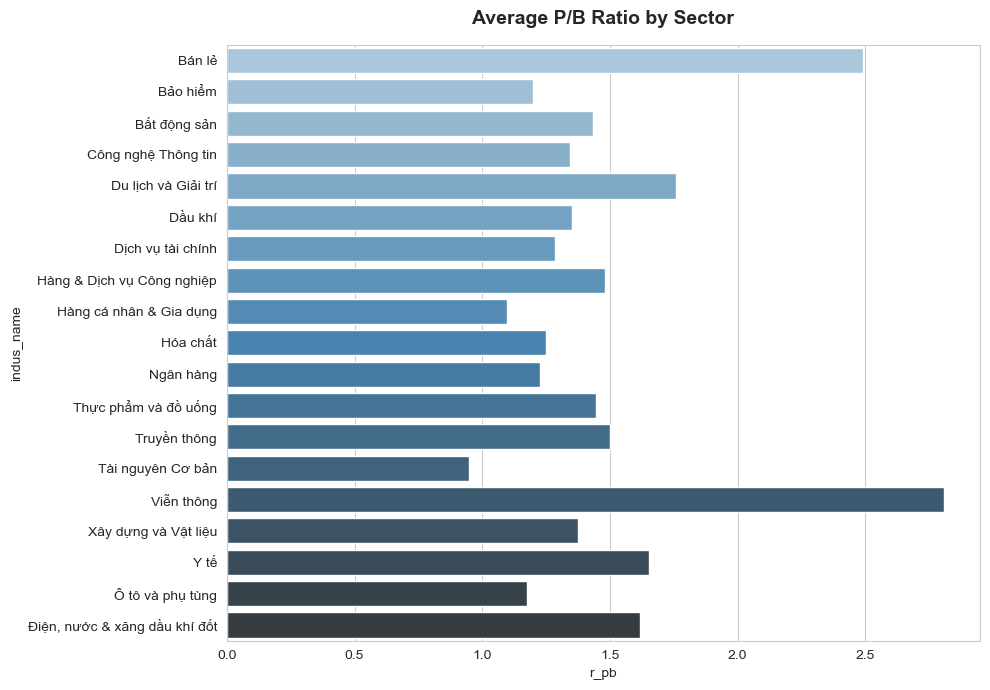

In [ ]:

fig, ax = plt.subplots(1, figsize=(10, 7))

# Biểu đồ P/B Ratio
sns.barplot(
    data=r_pb_sector_fundamentals,
    x='r_pb',
    y='indus_name',
    ax=ax,
    palette='Blues_d'
)

ax.set_title('Average P/B Ratio by Sector', fontsize=14, weight='bold', pad=15)
# Tinh chỉ
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

# Hiển thị đồ thị
plt.show()

C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\591961708.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\DELL Pre 7670\AppData\Local\Temp\ipykernel_46996\591961708.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




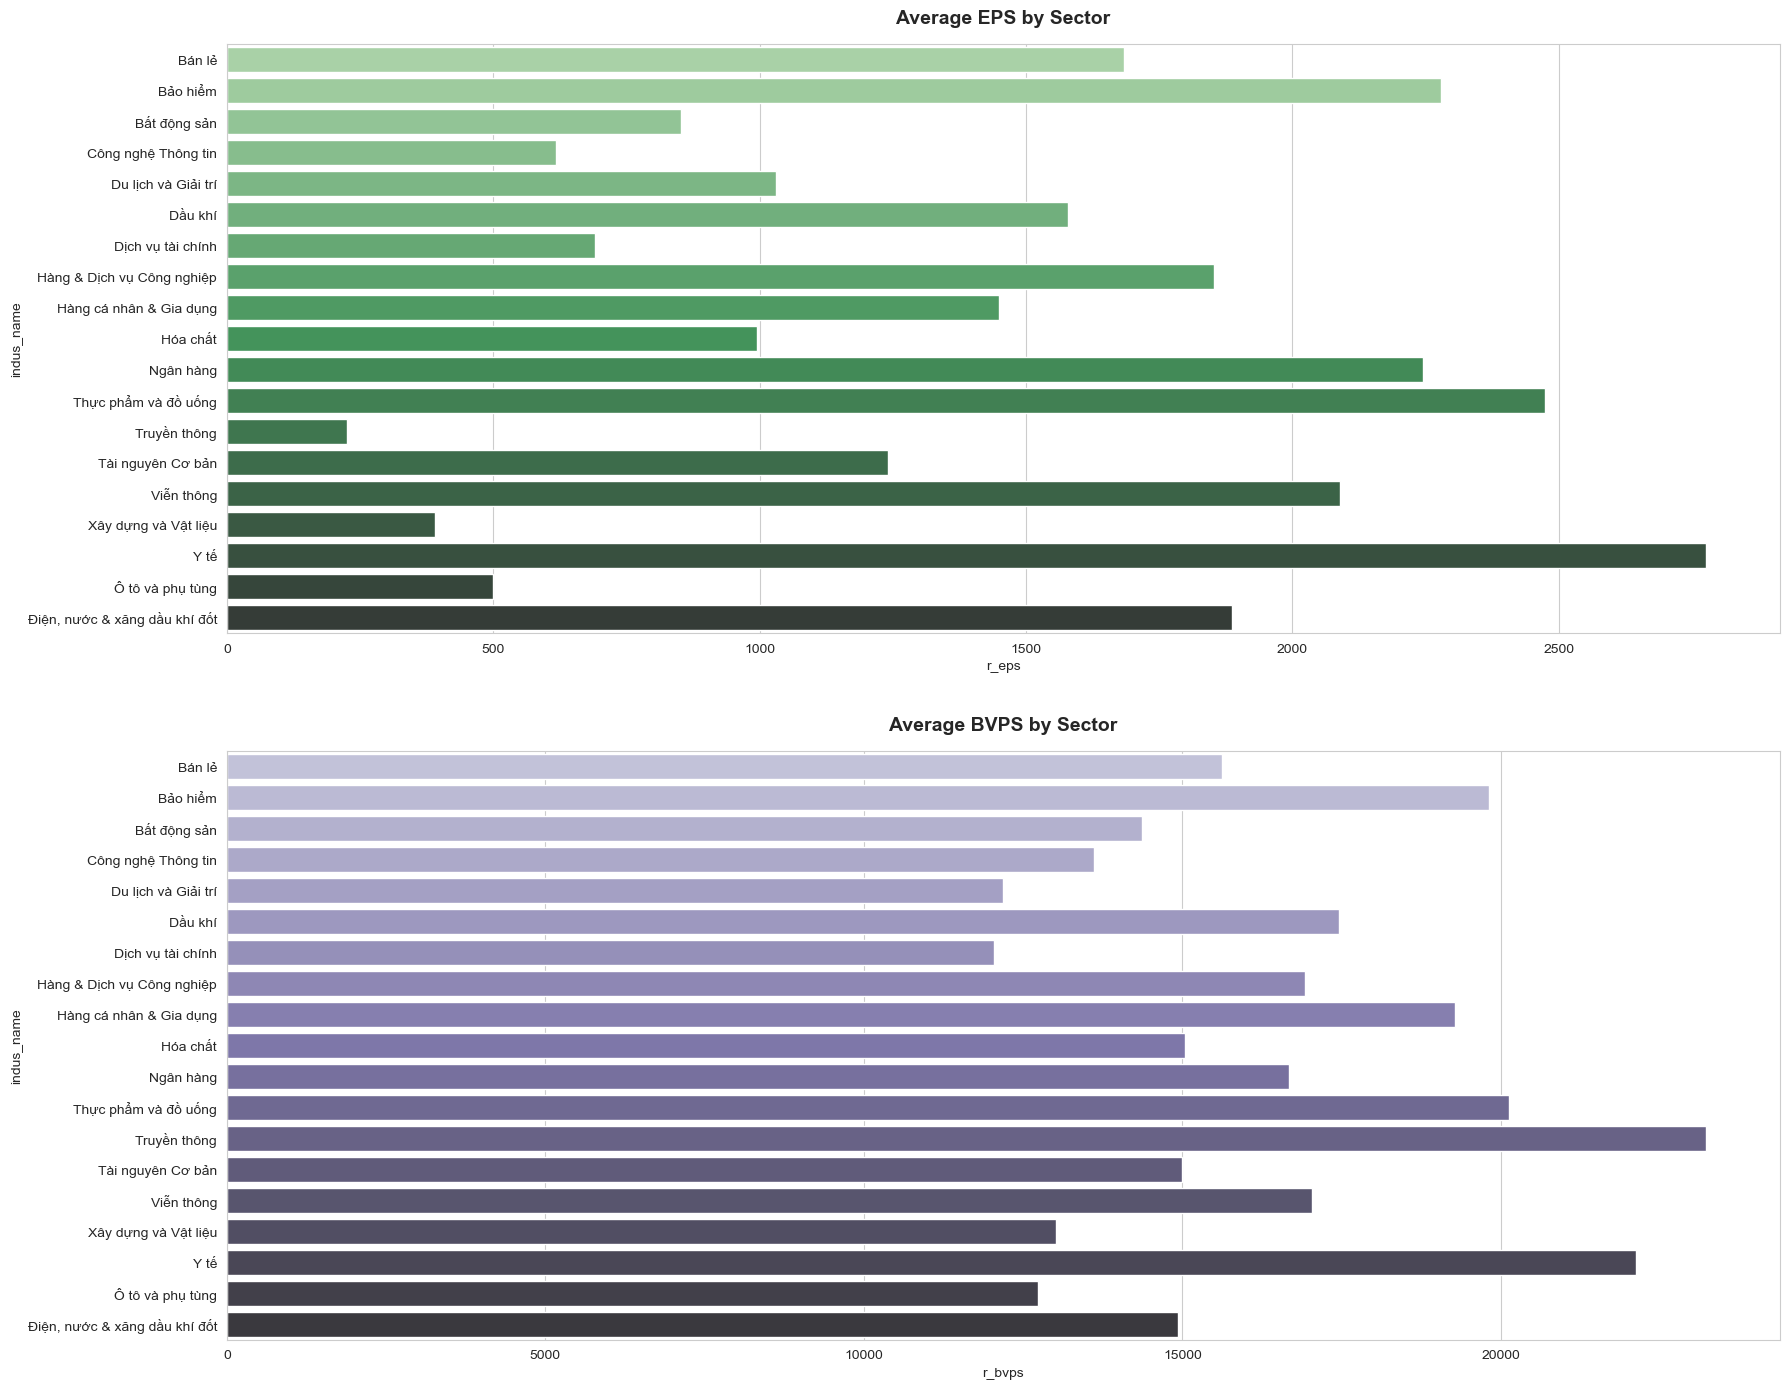

In [54]:
# Thiết kế lại đồ thị
fig, axes = plt.subplots(2, figsize=(18, 14))

# Biểu đồ EPS
sns.barplot(
    data=r_eps_sector_fundamentals,
    x='r_eps',
    y='indus_name',
    ax=axes[0],
    palette='Greens_d'
)
axes[0].set_title('Average EPS by Sector', fontsize=14, weight='bold', pad=15)

# Biểu đồ BVPS
sns.barplot(
    data=r_bvps_sector_fundamentals,
    x='r_bvps',
    y='indus_name',
    ax=axes[1],
    palette='Purples_d'
)
axes[1].set_title('Average BVPS by Sector', fontsize=14, weight='bold', pad=15)

# Tinh chỉ
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

# Hiển thị đồ thị
plt.show()